# Visualizing Crime Incident Reports in Boston

> In this episode of "Ankit tries to convince his flatmate that neighbourhoods in Boston are safer than they are made out to be.", we'll look at some of the data that we've collected about crime incidents in Boston. 

- toc: false 
- badges: true
- comments: true
- categories: [visualization]

<!-- warning for the reader on how deciding debates with data is based on several assumptions. Dangerous assumptions which must not be ignored. -->

## Introduction 

Moving to a new city in the US is a big deal. The rent is high. It often makes financial sense to move in with more people. This also means that one has to be considerate of other people's preferences and opinions when looking for apartments. At 9pm on a Monday, my flatmate informed me that he was having trouble convincing another flatmate that a certain neighbourhood in Boston was safe or at least as safe as where we currently live. This sounded like a nice Toy Problem to me. Something that I could use **Data Visualization** to help me with. After all, I had taken CS6250. I wasn't going to let [Prof. Michelle Borkin](https://www.ccs.neu.edu/home/borkin/) down. 


This exploration did not start with me looking for other implementations to place my work against but as an innocent exploration of the medium that is code and data. As I worked on the project, I also looked up if others had attempted to set sail on a similar voyage and of course, people had, many of them. A few of the projects are highlighted below.

- [This blogpost](https://towardsdatascience.com/analysis-of-boston-crime-incident-open-data-using-pandas-5ff2fd6e3254) by Riley Huang was a wonderful read. Riley does a brilliant job of using a dataset that they are passionate about and coming up with a story and designing a learning plan around it. I'm glad I found this blogpost before I posted this one. Riley uses Python and Pandas.

- [This blogpost](http://brianford.tech/crimeData/) by Brian Ford of Wentworth Institute of Technology is another great read. Brian uses the data to make a web application using the Google Maps API. Brian uses Web Technologies to make the application.

- [This blogpost](https://github.com/namas191297/boston_crime_analysis/blob/master/boston_crime_analysis.ipynb) by Namas Bhandari is a short jupyter notebook that performs a brief exploration of the data.

- [This tableau dashboard](https://public.tableau.com/profile/amulya.aankul#!/vizhome/BostonCrimePresentation-updated/GasBuddy) by [Amulya Aankul](https://www.linkedin.com/in/aankul/) of Northeastern University is another great read. Amulya uses the data to make an effective tableau dashboard with slides to guide the reader through. Amulya also attempts to infer causal factors that could affect crime. Amulya uses datasets in addition to the Boston Crime dataset to build a narrative.

Over the course of the project, I decided to also explore ways to grouping the data as we will see soon.


## Collecting the Data

The City of Boston as part of the Open Data Project publishes civic data on the [Analyze Boston](https://data.boston.gov/) website. We are interested in [Crime Incident Reports](https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system).

![](./imgs/2/dataGrab.png)

The data for each year from 2015 is available as a separate csv file. There are two additional `.xlsx` files for the offense codes and the different field descriptions. Let us begin by scraping the download links off of the website. The download links are parents to the `<i>` tags that have the class `icon-download`.

Let's begin by importing the necessary libraries. Click on show to see the imports.

In [122]:
#collapse-hide

# importing libraries

# for web scraping 
from bs4 import BeautifulSoup
import requests as r


# for data wrangling
import pandas as pd
from pandas import DateOffset
import json
import uuid
import datetime
import numpy as np
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from minisom import MiniSom    

# for plotting
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
import pydot
import matplotlib.colors as mcolors
import random
import math
import matplotlib.dates as mdates


# for map plotting
import folium
from folium.plugins import HeatMap, FastMarkerCluster, HeatMapWithTime
from IPython.display import IFrame, display, Markdown, Latex, SVG, HTML
import branca.colormap
from IPython.display import Image as imgIpython



# misc
from tqdm import tqdm
import os
from collections import defaultdict

In [2]:
#hide
sns.set_style("whitegrid")

In [3]:
#hide

# ┌────────────────────────────────────────────┐
# │                                            │
# │                                            │
# │      Note : Please use the saved data      │
# │             to avoid sending frequent      │
# │             requests to boston.gov         │
# │                                            │
# │      Run this cell if you are running      │
# │      this notebook only to explore the     │
# │      viz(s). Try not to scrape too much    │
# │                                            │
# └────────────────────────────────────────────┘


combined_typed = pd.read_csv("./data/combined_typed.csv", dtype={
        "INCIDENT_NUMBER": "str",
        "OFFENSE_CODE": "str",
        "OFFENSE_CODE_GROUP": "str",
        "OFFENSE_DESCRIPTION": "str",
        "DISTRICT": "str",
        "REPORTING_AREA": "str",
        "SHOOTING": "bool",
        "DAY_OF_WEEK": "str",
        "UCR_PART": "str",
        "STREET": "str",
        "Location": "str",
    },low_memory=False)
combined_typed["OCCURRED_ON_DATE"]  = pd.to_datetime(combined_typed["OCCURRED_ON_DATE"])
c_indexed = combined_typed.set_index('OCCURRED_ON_DATE')
c_indexed_grouped = c_indexed.groupby(['OCCURRED_ON_DATE'])

We begin by getting the `html` source for the page. This can be achived using a simple `GET` request to the URL.

In [3]:
url = "https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system"
res = r.get(url)

Next we use the `BeautifulSoup` library to parse the html source. Using the parsed output we select the csv and xlsx download links and download them.

In [4]:
soup = BeautifulSoup(res.text, "html.parser")
downloadBtns = soup.find_all('i', {"class": "icon-download"})
urls = [ btn.parent['href'] for btn in downloadBtns ]

csvLinks = [ url for url in urls if url.endswith('.csv') ]
xlLinks = [ url for url in urls if url.endswith('.xlsx') ]

from tqdm import tqdm
dfs = []

os.makedirs("./data", exist_ok=True)

for link in tqdm(csvLinks):
    # downloading using requests
    # and writing to a file
    res = r.get(link)
    with open("./data/" + link.split('/')[-1],'w') as f:
        f.write(res.text)
    df = pd.read_csv("./data/" + link.split('/')[-1], low_memory=False)
    dfs.append(df)
    
xl_dfs = []
for link in tqdm(xlLinks):
    # downloading using requests
    # and writing to a file
    res = r.get(link)
    with open("./data/" + link.split('/')[-1],'wb') as f:
        f.write(res.content)
    df_xl = pd.read_excel("./data/" + link.split('/')[-1])
    xl_dfs.append(df)

100%|███████████████████████████████████████████████| 8/8 [01:43<00:00, 12.89s/it]


## Looking at the Data

We then concat the dataframes into a single dataframe and take a look at it.

In [ ]:
combined = pd.concat(dfs)
combined.to_csv("./data/combined.csv")

Let's take a look at the datatypes of the columns.

In [6]:
#collapse-hide
combined.dtypes

INCIDENT_NUMBER         object
OFFENSE_CODE             int64
OFFENSE_CODE_GROUP      object
OFFENSE_DESCRIPTION     object
DISTRICT                object
REPORTING_AREA          object
SHOOTING                object
OCCURRED_ON_DATE        object
YEAR                     int64
MONTH                    int64
DAY_OF_WEEK             object
HOUR                     int64
UCR_PART                object
STREET                  object
Lat                    float64
Long                   float64
Location                object
dtype: object

Let's fix the data types for the columns and also fill in NA values. The Offense codes are four digit codes. We will use the zfill function to fill in the missing digits with 0s.

In [7]:
combined_typed = combined.astype(
    {
        "INCIDENT_NUMBER": "str",
        "OFFENSE_CODE": "str",
        "OFFENSE_CODE_GROUP": "str",
        "OFFENSE_DESCRIPTION": "str",
        "DISTRICT": "str",
        "REPORTING_AREA": "str",
        "SHOOTING": "bool",
        "OCCURRED_ON_DATE": "datetime64",
        "DAY_OF_WEEK": "str",
        "UCR_PART": "str",
        "STREET": "str",
        "Location": "str",
    }
)
combined_typed.fillna("", inplace=True)
combined_typed["OFFENSE_CODE"] = combined_typed["OFFENSE_CODE"].map(lambda x: x.zfill(4))
# drop duplicates
combined_typed.drop_duplicates(inplace=True)
combined_typed.to_csv("./data/combined_typed.csv",index=False)
combined_typed.head()


INCIDENT_NUMBER OFFENSE_CODE OFFENSE_CODE_GROUP  \
0       S87066666         3301                nan   
1       225520077         3115                nan   
2       222934485         3831                nan   
3       222924960         3301                nan   
4       222648862         3831                nan   

                     OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  SHOOTING  \
0                         VERBAL DISPUTE       B2            300     False   
1                     INVESTIGATE PERSON      D14            786     False   
2  M/V - LEAVING SCENE - PROPERTY DAMAGE       B2            319     False   
3                         VERBAL DISPUTE      C11            355     False   
4  M/V - LEAVING SCENE - PROPERTY DAMAGE       B2            288     False   

     OCCURRED_ON_DATE  YEAR  MONTH DAY_OF_WEEK  HOUR UCR_PART          STREET  \
0 2022-04-07 19:30:00  2022      4    Thursday    19      nan  THORNTON PLACE   
1 2022-02-02 00:00:00  2022      2   Wednesday     0      nan   WASHINGTON ST   
2 2022-05-14 20:50:00  2022      5    Saturday    20      nan   BLUE HILL AVE   
3 2022-04-09 16:30:00  2022      4    Saturday    16      nan       GIBSON ST   
4 2022-02-05 18:25:00  2022      2    Saturday    18      nan   WASHINGTON ST   

         Lat       Long                                  Location  
0        0.0        0.0                                    (0, 0)  
1  42.343081 -71.141723   (42.34308127134165, -71.14172267328729)  
2  42.308038 -71.083592   (42.30803768051951, -71.08359213073199)  
3  42.297555 -71.059709   (42.29755532959655, -71.05970910242573)  
4  42.329748  -71.08454  (42.329748204791635, -71.08454011649543)

Let's look at the number of reports per year.

In [10]:
# number of reports per year
year_counts_df = pd.DataFrame(
                        [[k,v] for k,v in combined_typed.groupby(['YEAR'])['YEAR'].count().to_dict().items()],
                        columns=['YEAR', 'COUNT']
                    )
year_counts_df

YEAR   COUNT
0  2015   53404
1  2016   99281
2  2017  101198
3  2018   98727
4  2019   87184
5  2020   70894
6  2021   71721
7  2022   38519

Oh right we can plot the values and take a look at them visually too.

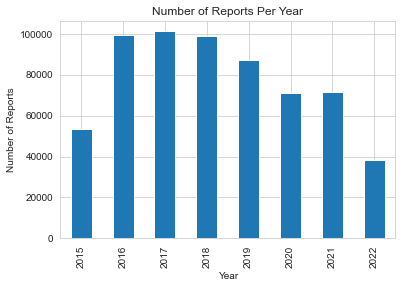

In [11]:
ax = year_counts_df.plot(kind='bar', x='YEAR', y='COUNT')
ax.set_title("Number of Reports Per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Reports")
ax.legend().remove()

Let's now take a look at the number of reports per offense code for the entire dataset.

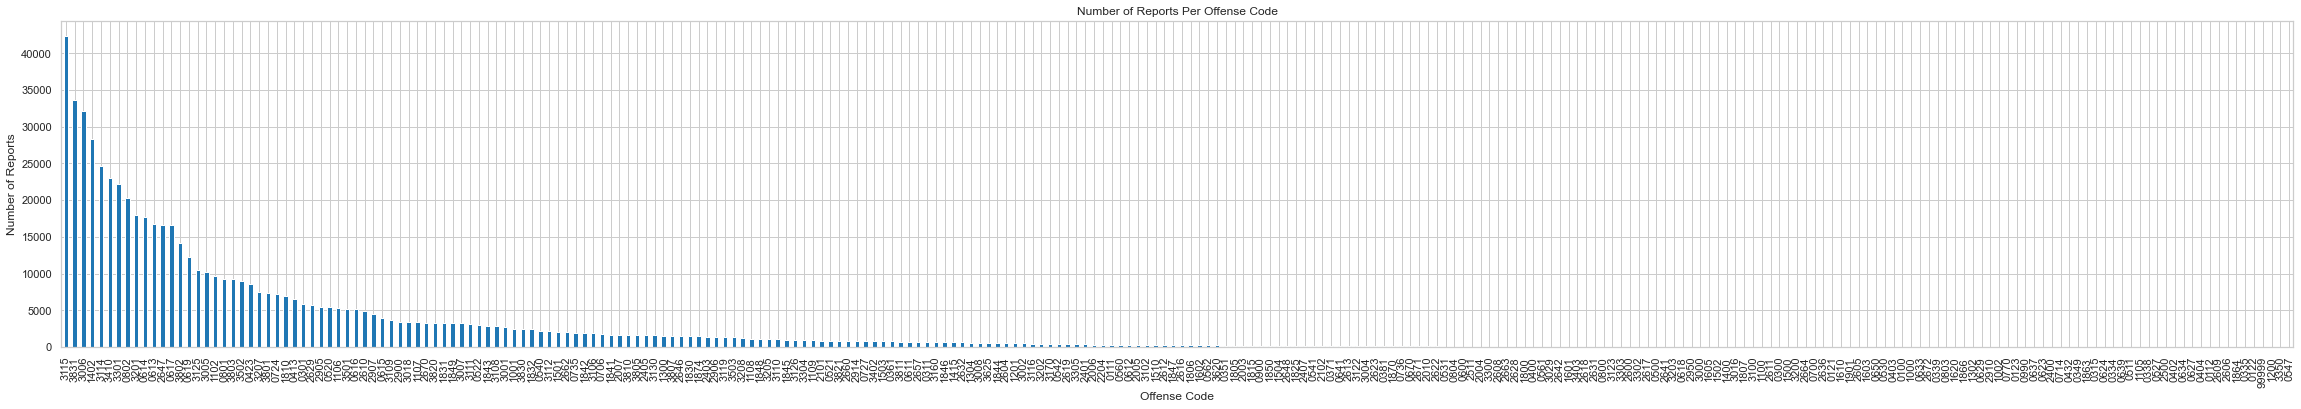

In [12]:
sns.set_context("notebook")
offense_plot = combined_typed['OFFENSE_CODE'].value_counts().plot(kind='bar',figsize=(40,6))
offense_plot.set_title("Number of Reports Per Offense Code")
offense_plot.set_xlabel("Offense Code")
offense_plot.set_ylabel("Number of Reports")
offense_plot.legend().remove()

Ok That's a lot of Offense Codes. Making sense of this plot will need a really large monitor given how skewed the aspect ratio is. Let's first try to take a look at the 25 most common offense codes, their descriptions and their code groups to get a feel for the data. 

In [13]:
top25_codes = combined_typed[['OFFENSE_CODE','OFFENSE_DESCRIPTION','OFFENSE_CODE_GROUP']]\
                .value_counts()\
                .head(25)\
                .reset_index(name='COUNTS')
top25_codes 

OFFENSE_CODE                    OFFENSE_DESCRIPTION  \
0          3006          SICK/INJURED/MEDICAL - PERSON   
1          3115                     INVESTIGATE PERSON   
2          3831  M/V - LEAVING SCENE - PROPERTY DAMAGE   
3          1402                              VANDALISM   
4          0802               ASSAULT SIMPLE - BATTERY   
5          3301                         VERBAL DISPUTE   
6          3410                    TOWED MOTOR VEHICLE   
7          3114                   INVESTIGATE PROPERTY   
8          0617            LARCENY THEFT FROM BUILDING   
9          2647              THREATS TO DO BODILY HARM   
10         3201                        PROPERTY - LOST   
11         0614  LARCENY THEFT FROM MV - NON-ACCESSORY   
12         3125                         WARRANT ARREST   
13         0613                    LARCENY SHOPLIFTING   
14         3802        M/V ACCIDENT - PROPERTY  DAMAGE   
15         0619                     LARCENY ALL OTHERS   
16         3803         M/V ACCIDENT - PERSONAL INJURY   
17         0413         ASSAULT - AGGRAVATED - BATTERY   
18         3502               MISSING PERSON - LOCATED   
19         1102        FRAUD - FALSE PRETENSE / SCHEME   
20         2629                             HARASSMENT   
21         3207                       PROPERTY - FOUND   
22         3501                         MISSING PERSON   
23         0724                             AUTO THEFT   
24         2610                            TRESPASSING   

                 OFFENSE_CODE_GROUP  COUNTS  
0                Medical Assistance   20968  
1                Investigate Person   20410  
2   Motor Vehicle Accident Response   17962  
3                         Vandalism   16565  
4                    Simple Assault   16338  
5                   Verbal Disputes   14469  
6                             Towed   12449  
7              Investigate Property   12358  
8                           Larceny   10075  
9                             Other   10058  
10                    Property Lost   10047  
11       Larceny From Motor Vehicle    9753  
12                  Warrant Arrests    9660  
13                          Larceny    8813  
14  Motor Vehicle Accident Response    7318  
15                          Larceny    6715  
16  Motor Vehicle Accident Response    5601  
17               Aggravated Assault    5350  
18           Missing Person Located    5156  
19                            Fraud    5044  
20                       Harassment    4530  
21                   Property Found    4073  
22          Missing Person Reported    3918  
23                       Auto Theft    3908  
24                            Other    3541

Let us also take a look at the top 5 most common offense codes for each year.

In [14]:
#collapse-hide
df2015 = combined_typed[(combined_typed['YEAR'] == 2015)]
top5_codes_2015 = df2015[['OFFENSE_CODE','OFFENSE_DESCRIPTION']].value_counts().head(5).reset_index(name='COUNTS')
display(Markdown('**Top 5 Codes in 2015:**'))
top5_codes_2015

**Top 5 Codes in 2015:**

OFFENSE_CODE                    OFFENSE_DESCRIPTION  COUNTS
0         1402                              VANDALISM    2659
1         3831  M/V - LEAVING SCENE - PROPERTY DAMAGE    2651
2         3115                     INVESTIGATE PERSON    2511
3         0802               ASSAULT SIMPLE - BATTERY    2393
4         3006          SICK/INJURED/MEDICAL - PERSON    2384

In [15]:
#collapse-hide
df2016 = combined_typed[(combined_typed['YEAR'] == 2016)]
top5_codes_2016 = df2016[['OFFENSE_CODE','OFFENSE_DESCRIPTION']].value_counts().head(5).reset_index(name='COUNTS')
display(Markdown("**Top 5 Codes in 2016:**"))
top5_codes_2016

**Top 5 Codes in 2016:**

OFFENSE_CODE                    OFFENSE_DESCRIPTION  COUNTS
0         3115                     INVESTIGATE PERSON    5775
1         3006          SICK/INJURED/MEDICAL - PERSON    5495
2         3831  M/V - LEAVING SCENE - PROPERTY DAMAGE    5071
3         1402                              VANDALISM    4954
4         0802               ASSAULT SIMPLE - BATTERY    4471

In [16]:
#collapse-hide
df2017 = combined_typed[(combined_typed['YEAR'] == 2017)]
top5_codes_2017 = df2017[['OFFENSE_CODE','OFFENSE_DESCRIPTION']].value_counts().head(5).reset_index(name='COUNTS')
display(Markdown("**Top 5 Codes in 2017:**"))
top5_codes_2017

**Top 5 Codes in 2017:**

OFFENSE_CODE                    OFFENSE_DESCRIPTION  COUNTS
0         3115                     INVESTIGATE PERSON    6668
1         3006          SICK/INJURED/MEDICAL - PERSON    6278
2         3831  M/V - LEAVING SCENE - PROPERTY DAMAGE    5221
3         1402                              VANDALISM    4773
4         0802               ASSAULT SIMPLE - BATTERY    4636

In [17]:
#collapse-hide
df2018 = combined_typed[(combined_typed['YEAR'] == 2018)]
top5_codes_2018 = df2018[['OFFENSE_CODE','OFFENSE_DESCRIPTION']].value_counts().head(5).reset_index(name='COUNTS')
display(Markdown("**Top 5 Codes in 2018:**"))
top5_codes_2018

**Top 5 Codes in 2018:**

OFFENSE_CODE                    OFFENSE_DESCRIPTION  COUNTS
0         3006          SICK/INJURED/MEDICAL - PERSON    6811
1         3115                     INVESTIGATE PERSON    5460
2         3831  M/V - LEAVING SCENE - PROPERTY DAMAGE    5019
3         0802               ASSAULT SIMPLE - BATTERY    4838
4         3301                         VERBAL DISPUTE    4423

In [18]:
#collapse-hide
df2019 = combined_typed[(combined_typed['YEAR'] == 2019)]
top5_codes_2019 = df2019[['OFFENSE_CODE','OFFENSE_DESCRIPTION']].value_counts().head(5).reset_index(name='COUNTS')
display(Markdown("**Top 5 Codes in 2019:**"))
top5_codes_2019

**Top 5 Codes in 2019:**

OFFENSE_CODE                    OFFENSE_DESCRIPTION  COUNTS
0         3006          SICK/INJURED/MEDICAL - PERSON    5895
1         3115                     INVESTIGATE PERSON    5733
2         3831  M/V - LEAVING SCENE - PROPERTY DAMAGE    4910
3         0802               ASSAULT SIMPLE - BATTERY    3900
4         3114                   INVESTIGATE PROPERTY    3668

In [19]:
#collapse-hide
df2020 = combined_typed[(combined_typed['YEAR'] == 2020)]
top5_codes_2020 = df2020[['OFFENSE_CODE','OFFENSE_DESCRIPTION']].value_counts().head(5).reset_index(name='COUNTS')
display(Markdown("**Top 5 Codes in 2020:**"))
top5_codes_2020

**Top 5 Codes in 2020:**

OFFENSE_CODE                    OFFENSE_DESCRIPTION  COUNTS
0         3115                     INVESTIGATE PERSON    5122
1         3005                            SICK ASSIST    4236
2         3831  M/V - LEAVING SCENE - PROPERTY DAMAGE    3603
3         1402                              VANDALISM    3323
4         3114                   INVESTIGATE PROPERTY    3222

In [20]:
#collapse-hide
df2021 = combined_typed[(combined_typed['YEAR'] == 2021)]
top5_codes_2021 = df2021[['OFFENSE_CODE','OFFENSE_DESCRIPTION']].value_counts().head(5).reset_index(name='COUNTS')
display(Markdown("**Top 5 Codes in 2021:**"))
top5_codes_2021

**Top 5 Codes in 2021:**

OFFENSE_CODE                    OFFENSE_DESCRIPTION  COUNTS
0         3115                     INVESTIGATE PERSON    6841
1         3005                            SICK ASSIST    4969
2         3831  M/V - LEAVING SCENE - PROPERTY DAMAGE    4678
3         3114                   INVESTIGATE PROPERTY    3531
4         1402                              VANDALISM    3287

In [21]:
#collapse-hide
df2022 = combined_typed[(combined_typed['YEAR'] == 2022)]
top5_codes_2022 = df2022[['OFFENSE_CODE','OFFENSE_DESCRIPTION']].value_counts().head(5).reset_index(name='COUNTS')
display(Markdown("**Top 5 Codes in 2022:**"))
top5_codes_2022

**Top 5 Codes in 2022:**

OFFENSE_CODE                    OFFENSE_DESCRIPTION  COUNTS
0         3115                     INVESTIGATE PERSON    4172
1         1831                            SICK ASSIST    2926
2         3831  M/V - LEAVING SCENE - PROPERTY DAMAGE    2426
3         3114                   INVESTIGATE PROPERTY    1818
4         3410                    TOWED MOTOR VEHICLE    1669

Let's now take a look at a heatmap of the numbers of reports for the year 2021. We'll be using `folium` for map visualization. Let us also add markers that correspond to the agregated counts for a geographic region.

In [22]:
hmap = folium.Map(location=[42.336082675630315, -71.09991318861809], zoom_start=15,tiles='OpenStreetMap', )
data = list(zip(df2021.Lat.values, df2021.Long.values))

steps=20
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(hmap)


hm_wide = HeatMap( data,
                   min_opacity=0.2,
                   radius=17, blur=15, 
                   max_zoom=1, 
                   gradient=gradient_map,
                   name='heatmap'
                 )
hmap.add_child(hm_wide)
markers = FastMarkerCluster(data=data,name='markers')
hmap.add_child(markers)
folium.LayerControl().add_to(hmap)

hmap.save("../images/heatmap.html")

In [23]:
#collapse-hide
IFrame("/images/heatmap.html", width="100%", height="500px")

Keep in mind that this is the aggredgated-count heatmap for all incident types for 2021. To see the heatmap for a specific year we can change the line ```data = list(zip(df2021.Lat.values, df2021.Long.values))``` to our desired year. In order to see the heatmap for a sepecific indident type we can add a filter to the dframe. For example, to see the heatmap for all crimes involving the offense code `3115` we can add a filter to the dataframe like so: ```df2021[df2021.OFFENSE_CODE == '3115']```.

We can also take a look at a heatmap over time. For this we will use the folium plugin `HeatMapWithTime`. The data we need to past is a list of lists of locations. The index for the data will be our bins of time.

In [4]:
combined_typed["OCCURRED_ON_DATE"] = pd.to_datetime(combined_typed["OCCURRED_ON_DATE"])
c_indexed = combined_typed.set_index('OCCURRED_ON_DATE')
c_indexed_grouped = c_indexed.groupby(['OCCURRED_ON_DATE'])

Let's also define a helper function to convert a latitude and longitude string of the form `(42.3601, -71.0589)` to a tuple of floats.

In [25]:
# convert lat long string "(x,y)" to float tuple
def convert_lat_long(lat_long_str):
    lat_long_str = lat_long_str.replace('(','')
    lat_long_str = lat_long_str.replace(')','')
    lat_long_str = lat_long_str.split(',')
    lat = float(lat_long_str[0])
    long = float(lat_long_str[1])
    return [lat,long]

Let's resample the data to get the number of reports per Month and create a list of lists of locations for each month.

In [26]:
sampled = c_indexed.resample("M")
locations = sampled.agg(pd.Series.tolist)["Location"]
data = [ [ convert_lat_long(point) for point in timeframe] for timeframe in locations]
# remove points that are undefined and (0,0)
data = [point for point in data if point[0] != 0 and point[1] != 0]
data = [point for point in data if point[0] is not None and point[1] is not None]


All together now.

In [27]:

hmap = folium.Map(location=[42.336082675630315, -71.09991318861809], zoom_start=15,tiles='OpenStreetMap', )

steps=20
colormap = branca.colormap.linear.YlOrRd_09.scale(0, 1).to_step(steps)
gradient_map=defaultdict(dict)
for i in range(steps):
    gradient_map[1/steps*i] = colormap.rgb_hex_str(1/steps*i)
colormap.add_to(hmap)


hm_wide = HeatMapWithTime( data,
                   min_opacity=0.2,
                   radius=17, 
                   max_opacity=0.8,
                   gradient=json.dumps(gradient_map),
                 )
hmap.add_child(hm_wide)
hmap.save("../images/heatmap_time.html")

In [28]:
#collapse-hide
IFrame("/images/heatmap_time.html", width="100%", height="500px")

It is obvious that maps are excellent for visualizing geographical data. Their limits as a visual aid are put to the test when we have multiple data class types like in the case of incident reports. Naively we could visualize different classes with different colors. We 254 different classes. Using all of them would make the visualization immpossible to interpret. Using the viz principle of **Details on Demand**, another strategy would be to use brushing and linking to bind a set of selections from a less granualar visualization like a bar chart or a dropdown list (a table) to a map. 

The humble line chart is never one to disappoint. On that note, let us take a look at the number of counts per month for the time range as a time series line chart.

### Total Reports for Each Month

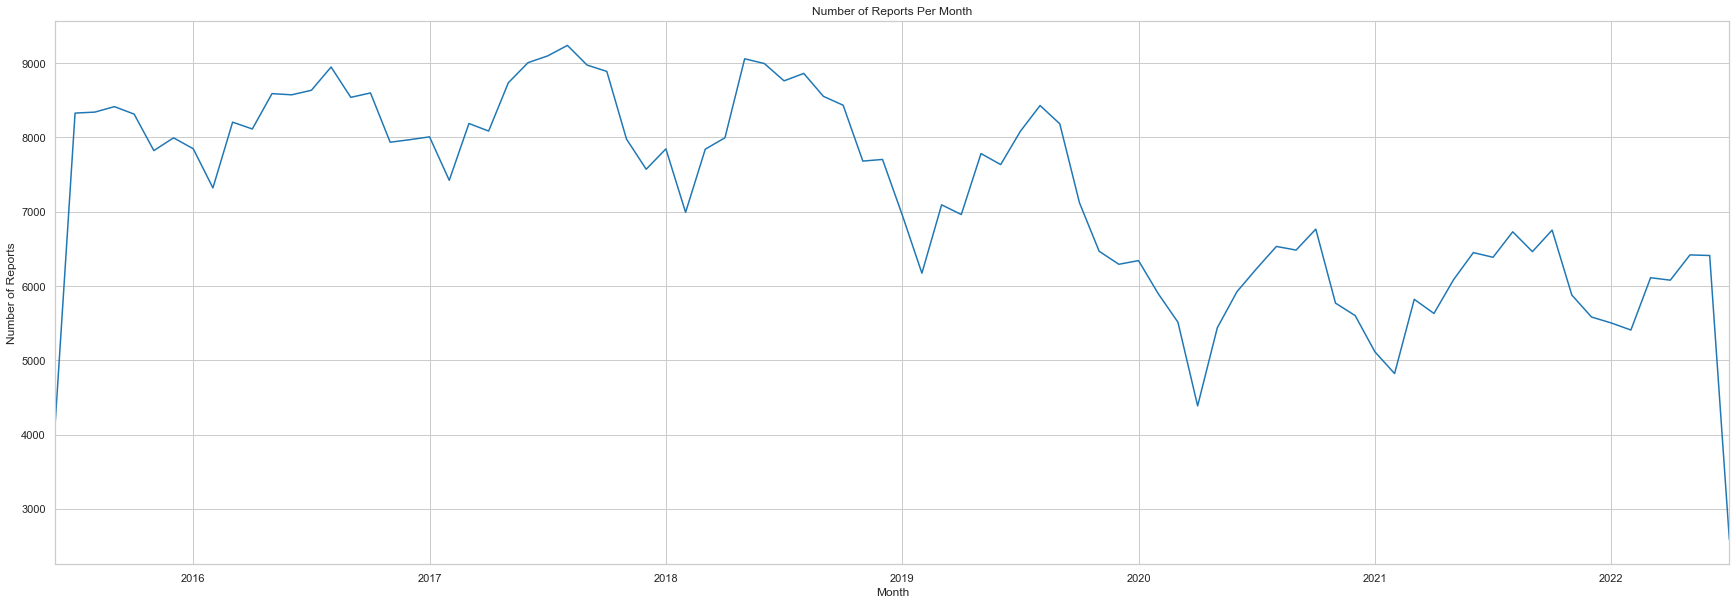

In [29]:
# resample to monthly
ax = c_indexed.resample("M").count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
ax.set_title("Number of Reports Per Month")
ax.set_xlabel("Month")
ax.set_ylabel("Number of Reports")
display(Markdown("### Total Reports per Month"))
ax.legend().remove()

We can get a more fine grained view of the data by taking a look at the number of counts per week for the time range.

### Total Reports for Each Week

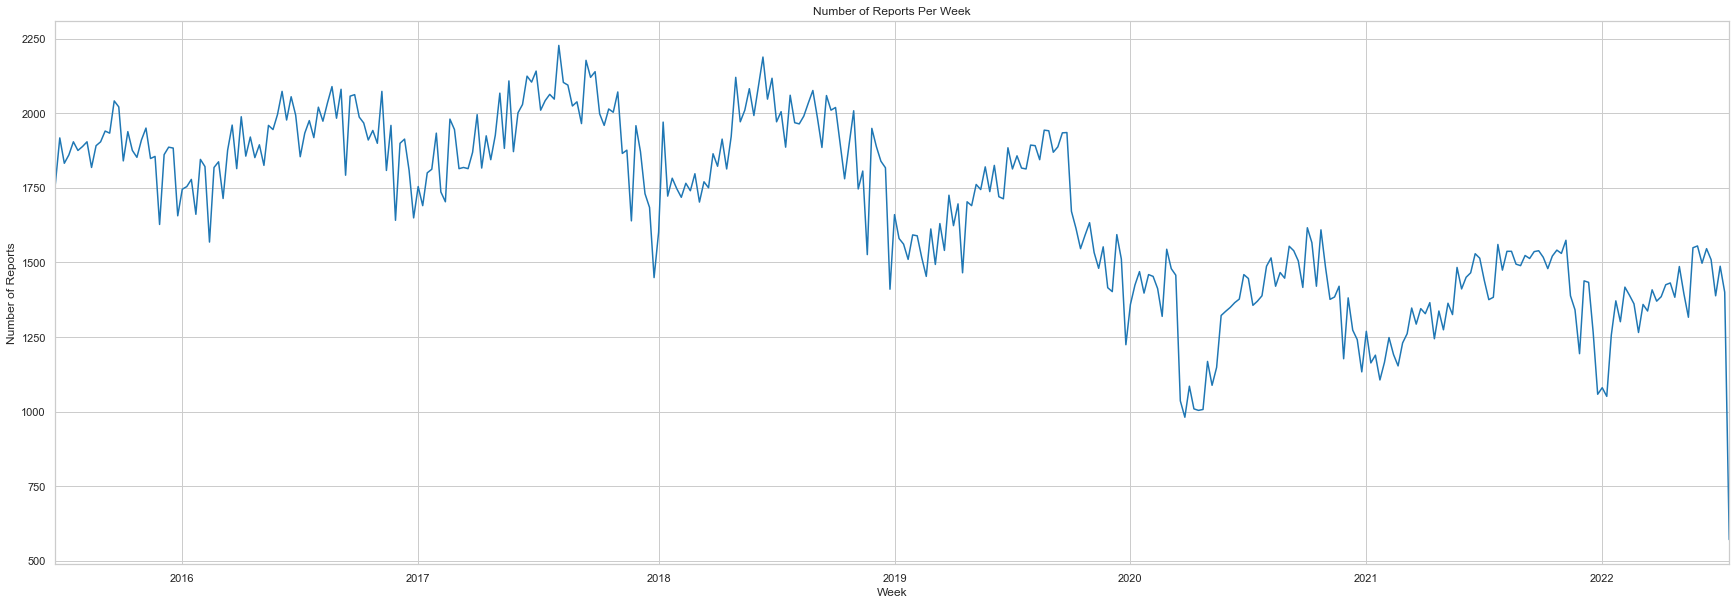

In [30]:
#collapse-hide
# resample weekly
ax = c_indexed.resample("W").count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
ax.set_title("Number of Reports Per Week")
ax.set_xlabel("Week")
ax.set_ylabel("Number of Reports")
display(Markdown("### Total Reports per Week"))
ax.legend().remove()

The data appears to be [seasonal](https://en.wikipedia.org/wiki/Seasonality) in nature. Lets take a look at a specific Incident Code.

### Reports for Code 0613 (LARCENY SHOPLIFTING) Grouped by Week

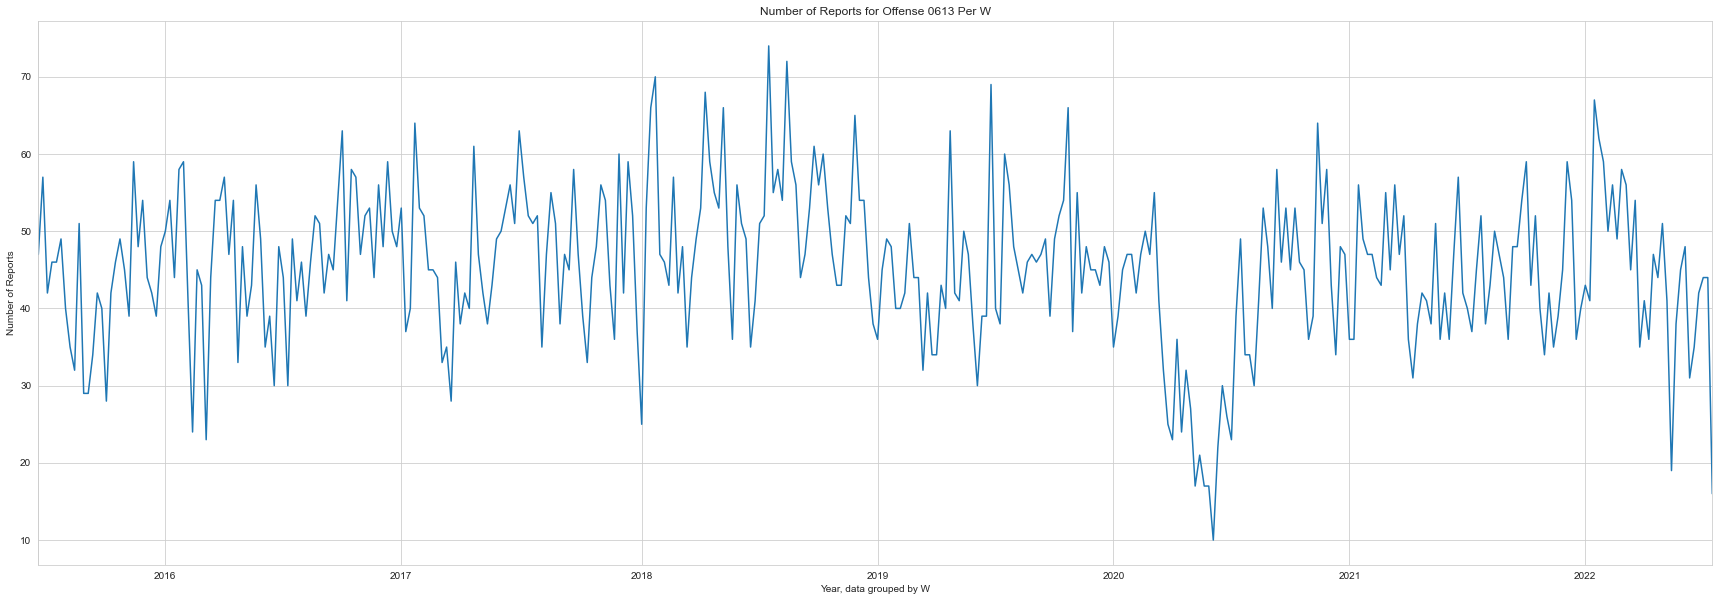

In [15]:
#collapse-hide
# select rows matching a specific offense code and resample weekly
offense_code = '0613'
time_scale = "W"
ax = c_indexed[c_indexed["OFFENSE_CODE"] == offense_code].resample(time_scale).count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
description = combined_typed[combined_typed["OFFENSE_CODE"] == offense_code]["OFFENSE_DESCRIPTION"].iloc[0]
ax.set_xlabel(f"Year, data grouped by {time_scale}")
ax.set_ylabel("Number of Reports")
ax.set_title(f"Number of Reports for Offense {offense_code} Per {time_scale}")
display(Markdown(f"### Reports for Code {offense_code} ({description}) Grouped by Week"))
ax.legend().remove()

Larceny seems to have a dip in the first half of  2020. The overall trend appears to be stable.

### Reports for Code 1831 (SICK ASSIST) Grouped by W

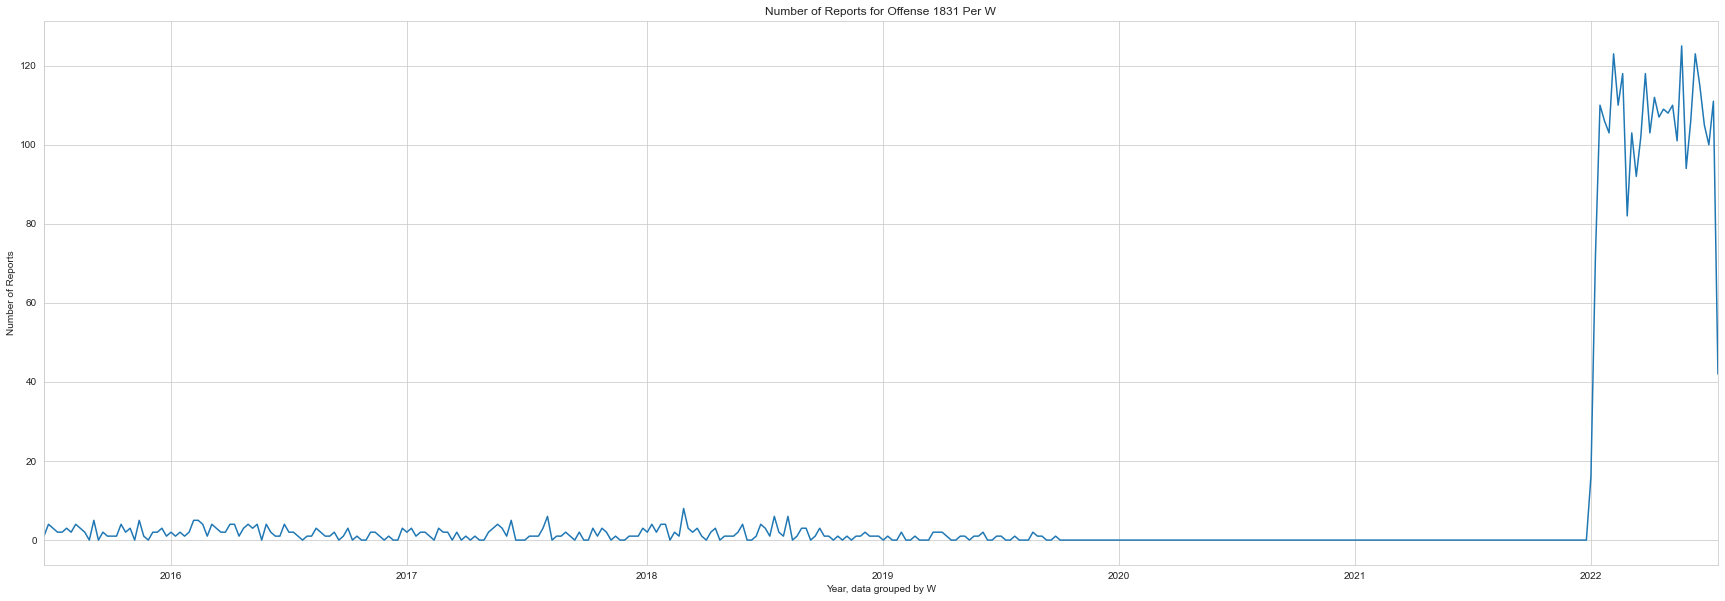

In [13]:
#collapse-hide
# select rows matching a specific offense code and resample weekly
offense_code = '1831'
time_scale = "W"

ax = c_indexed[c_indexed["OFFENSE_CODE"] == offense_code].resample(time_scale).count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
description = combined_typed[combined_typed["OFFENSE_CODE"] == offense_code]["OFFENSE_DESCRIPTION"].iloc[0]
ax.set_xlabel(f"Year, data grouped by {time_scale}")
ax.set_ylabel("Number of Reports")
ax.set_title(f"Number of Reports for Offense {offense_code} Per {time_scale}")
display(Markdown(f"### Reports for Code {offense_code} ({description}) Grouped by Week"))
ax.legend().remove()

Interestingly the number of sick assists have shot up in 2022. One can hypothesise that this is a filing error. The empty space between the end of 2019 and 2022 is likely due to the fact that COVID-19 induced filing delays. 

### Investigate Verbal Dispute Reports Grouped by Week

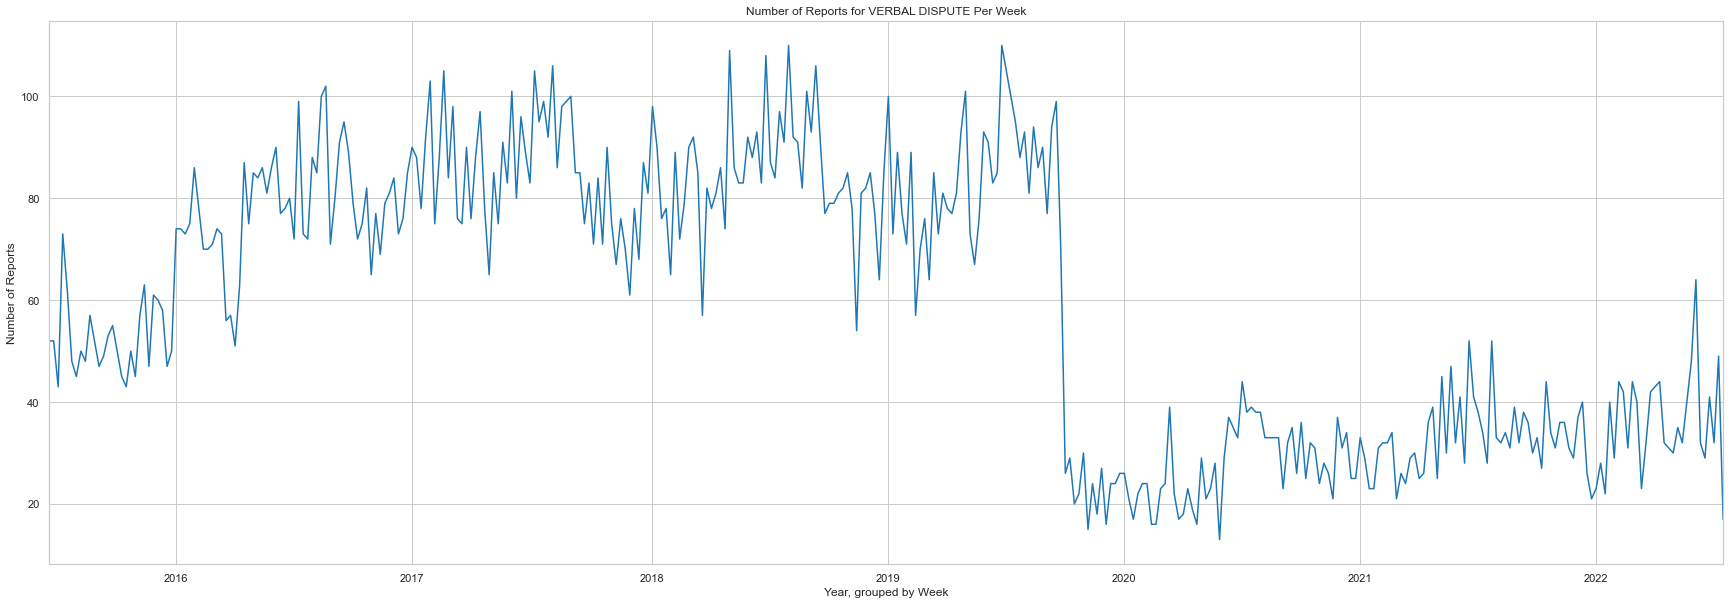

In [33]:
#collapse-hide
# select rows matching a specific offense description and resample weekly
ax = c_indexed[c_indexed["OFFENSE_DESCRIPTION"] == 'VERBAL DISPUTE'].resample("W").count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
ax.set_xlabel("Year, grouped by Week")
ax.set_ylabel("Number of Reports")
ax.set_title("Number of Reports for VERBAL DISPUTE Per Week")
display(Markdown("### Investigate Verbal Dispute Reports Grouped by Week"))
ax.legend().remove()

The onset of the pandemic also seems to correlate with a drop in the number of verbal disputes. Masks seem to have worked :bowtie:!

### Investigate Person Reports Grouped by Week

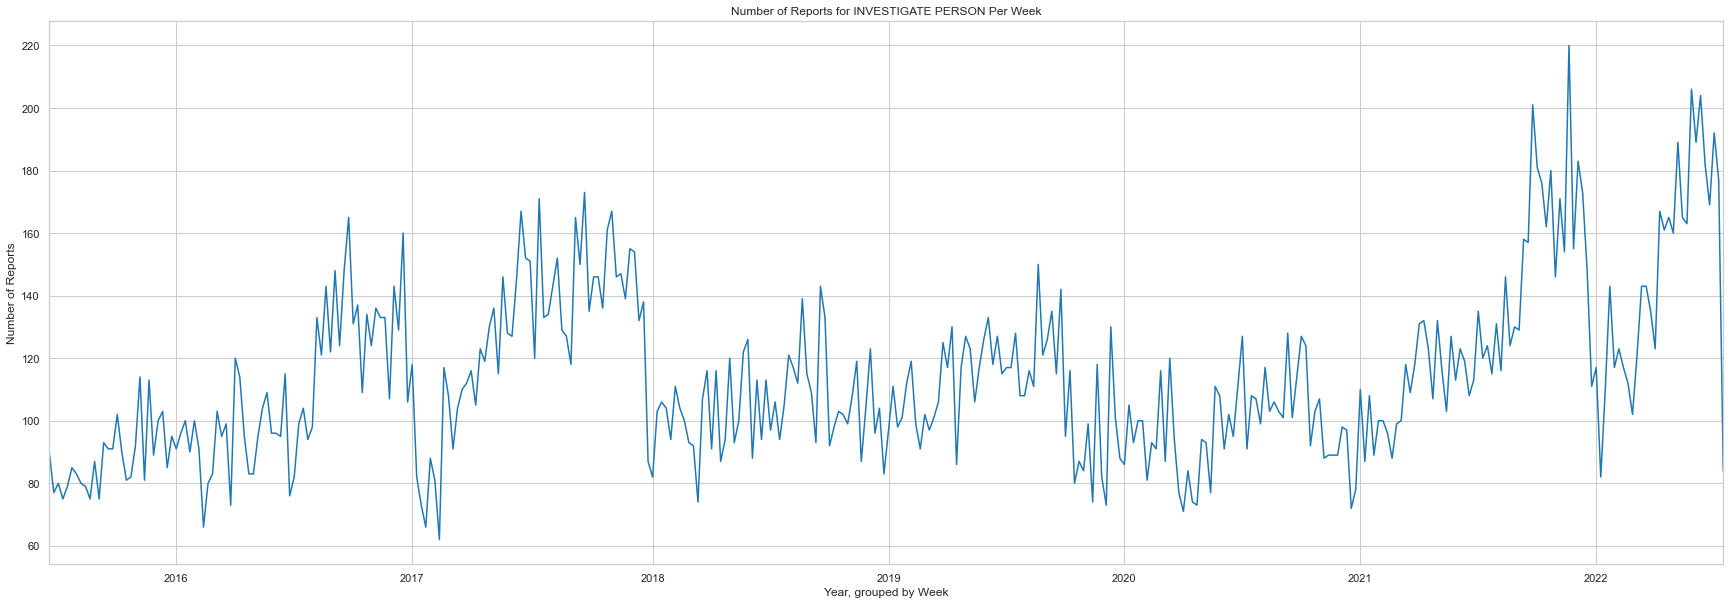

In [34]:
#collapse-hide
# select rows matching a specific offense description and resample weekly
ax = c_indexed[c_indexed["OFFENSE_DESCRIPTION"] == 'INVESTIGATE PERSON'].resample("W").count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
ax.set_xlabel("Year, grouped by Week")
ax.set_ylabel("Number of Reports")
ax.set_title("Number of Reports for INVESTIGATE PERSON Per Week")
display(Markdown("### Investigate Person Reports Grouped by Week"))
ax.legend().remove()

This looks interesting. There's some interesting end of the year peaking happening in the number of Investigate Person reports. There could be so many factors at play here. These demands futher inquiry.

### Shootings Grouped by Day

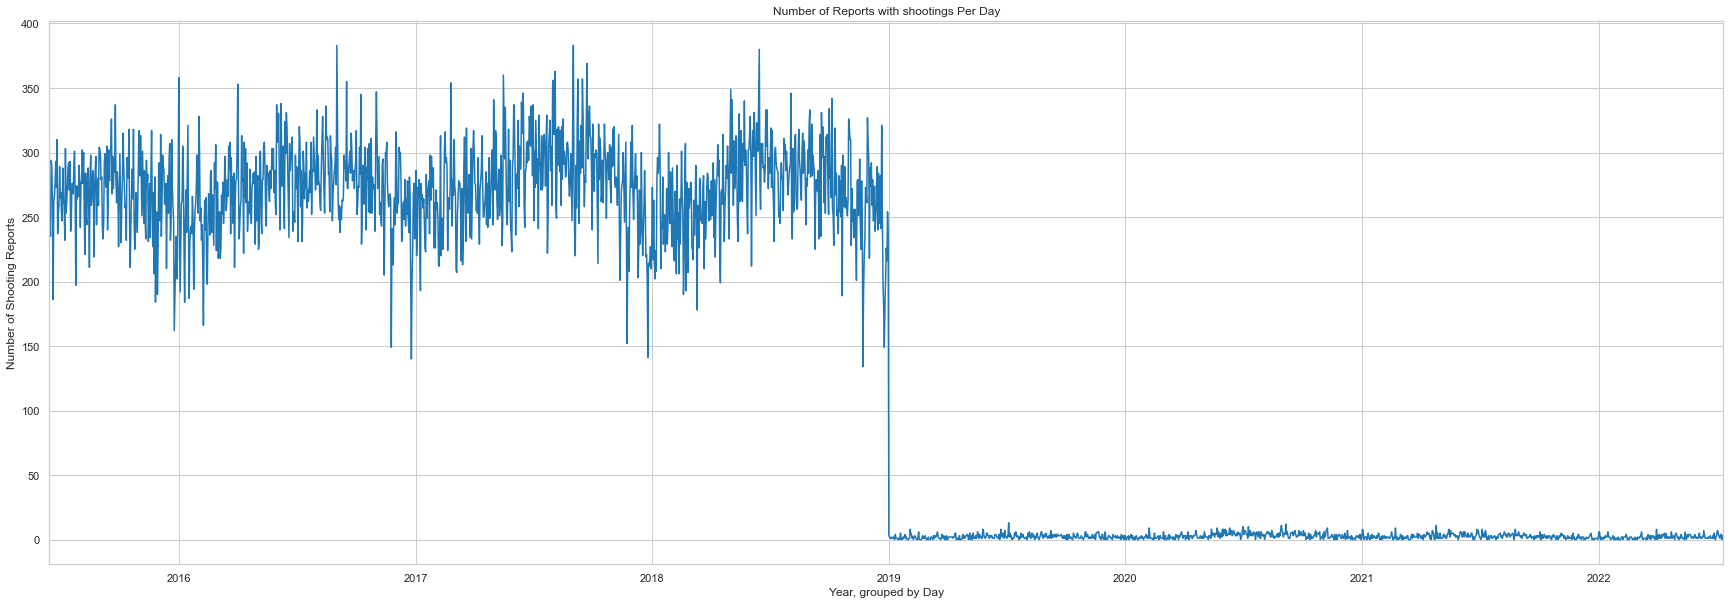

In [35]:
#collapse-hide
# select rows that have Shooting set to true and resample daily
ax = c_indexed[c_indexed["SHOOTING"] == True].resample("D").count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
ax.set_xlabel("Year, grouped by Day")
ax.set_ylabel("Number of Shooting Reports")
ax.set_title("Number of Reports with shootings Per Day")
display(Markdown("### Shootings Grouped by Day"))
ax.legend().remove()

Oh my! What everyone was waiting for. Shootings dropped after 2019? This is weird. Did they change the filing code? or Did shootings drop because of change in adminisitration?

### Shootings Grouped by Week

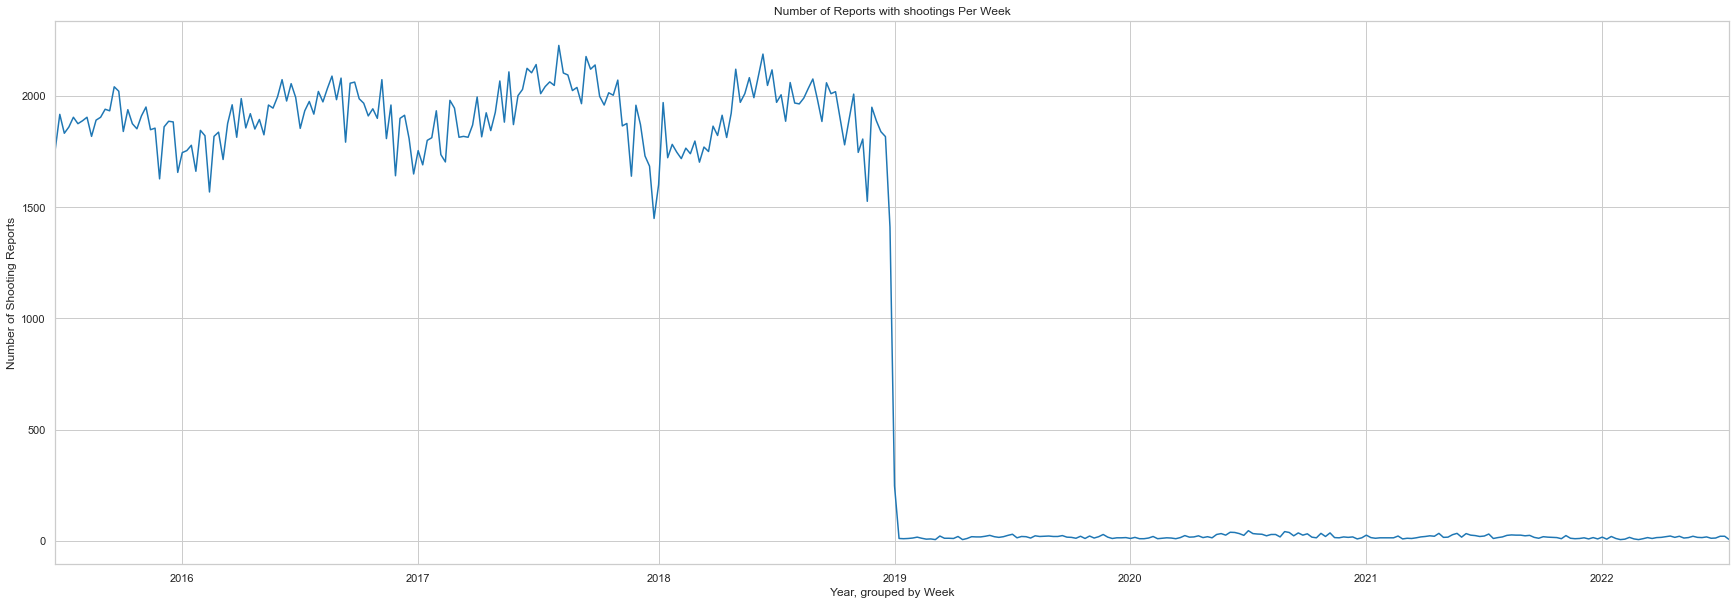

In [36]:
#hide
# select rows that have Shooting set to true and resample weekly
ax = c_indexed[c_indexed["SHOOTING"] == True].resample("W").count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
ax.set_xlabel("Year, grouped by Week")
ax.set_ylabel("Number of Shooting Reports")
ax.set_title("Number of Reports with shootings Per Week")
display(Markdown("### Shootings Grouped by Week"))
ax.legend().remove()

### Shootings Grouped by Month

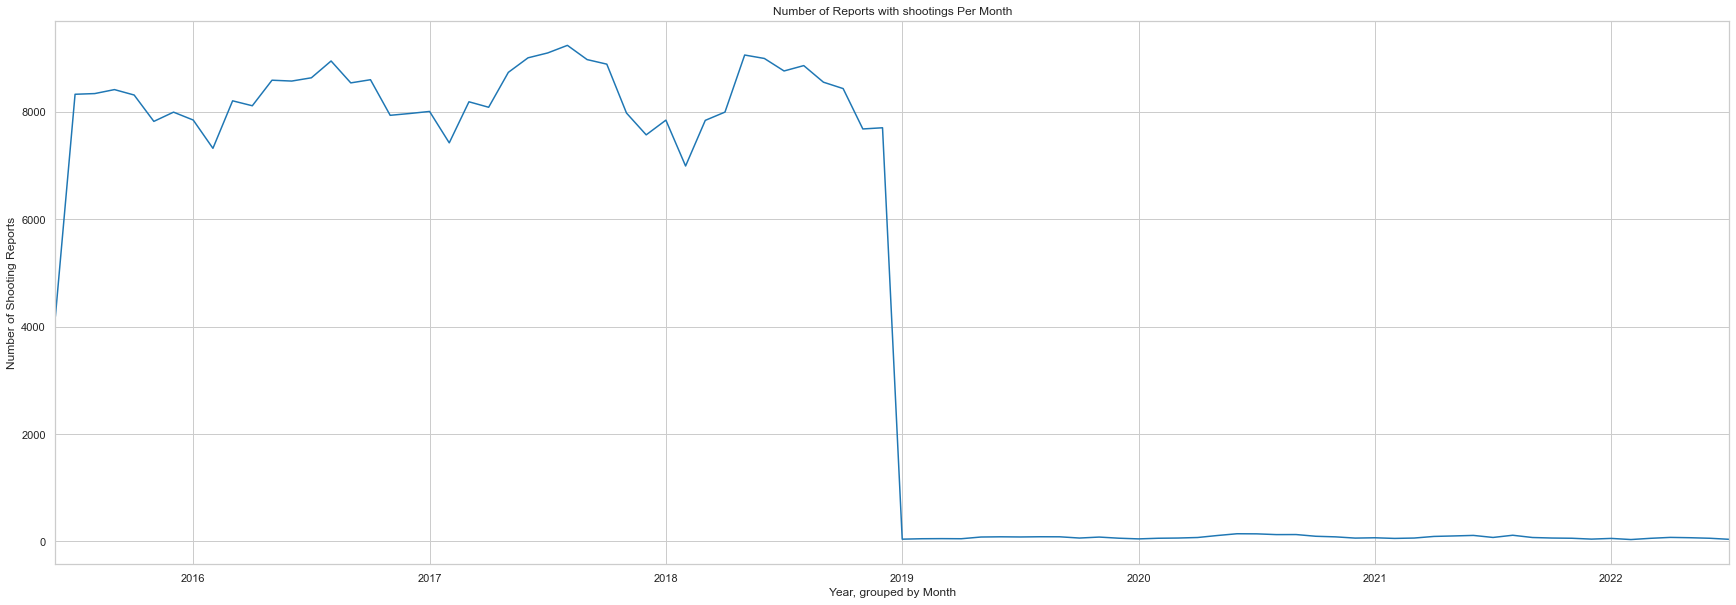

In [37]:
#hide
# select rows that have Shooting set to true and resample monthly
ax = c_indexed[c_indexed["SHOOTING"] == True].resample("M").count()["INCIDENT_NUMBER"].plot(figsize=(30,10))
ax.set_xlabel("Year, grouped by Month")
ax.set_ylabel("Number of Shooting Reports")
ax.set_title("Number of Reports with shootings Per Month")
display(Markdown("### Shootings Grouped by Month"))
ax.legend().remove()

That's a drastic dip in the number of shootings after 2019. Unfortunately I am not well equipped to answer why this is the case. Looking into it will be a future project.

In [38]:
#hide
# checking if we really have such a huge difference in shootings post 2019
date_before = datetime.date(2020, 7, 16)
date_after = datetime.date(2020, 7, 15)
c_indexed[(c_indexed["SHOOTING"] == True) & (pd.to_datetime(date_after) < c_indexed.index) &( c_indexed.index < pd.to_datetime(date_before))]
# we do have a huge difference. wow. ok. RQ maybe?

INCIDENT_NUMBER OFFENSE_CODE OFFENSE_CODE_GROUP  \
OCCURRED_ON_DATE                                                      
2020-07-15 20:00:00       202050096         0423                NaN   
2020-07-15 22:59:00       202050093         3114                NaN   
2020-07-15 01:23:00       202049824         3114                NaN   
2020-07-15 00:20:00       202049821         3114                NaN   

                      OFFENSE_DESCRIPTION DISTRICT REPORTING_AREA  SHOOTING  \
OCCURRED_ON_DATE                                                              
2020-07-15 20:00:00  ASSAULT - AGGRAVATED      E18            493      True   
2020-07-15 22:59:00  INVESTIGATE PROPERTY       B2            319      True   
2020-07-15 01:23:00  INVESTIGATE PROPERTY       A7             35      True   
2020-07-15 00:20:00  INVESTIGATE PROPERTY       B2            331      True   

                     YEAR  MONTH DAY_OF_WEEK  HOUR UCR_PART  \
OCCURRED_ON_DATE                                              
2020-07-15 20:00:00  2020      7   Wednesday    20      NaN   
2020-07-15 22:59:00  2020      7   Wednesday    22      NaN   
2020-07-15 01:23:00  2020      7   Wednesday     1      NaN   
2020-07-15 00:20:00  2020      7   Wednesday     0      NaN   

                                                                STREET  \
OCCURRED_ON_DATE                                                         
2020-07-15 20:00:00                                           AYLES RD   
2020-07-15 22:59:00                                        SCHUYLER ST   
2020-07-15 01:23:00  ORLEANS ST & SUMNER ST\nEAST BOSTON  MA 02128\...   
2020-07-15 00:20:00                                        COLUMBIA RD   

                           Lat       Long  \
OCCURRED_ON_DATE                            
2020-07-15 20:00:00  42.264071 -71.111523   
2020-07-15 22:59:00  42.309114 -71.086671   
2020-07-15 01:23:00  42.368114 -71.037982   
2020-07-15 00:20:00  42.312363 -71.068904   

                                                  Location  
OCCURRED_ON_DATE                                            
2020-07-15 20:00:00  (42.2640706820922, -71.1115230250528)  
2020-07-15 22:59:00  (42.3091142194586, -71.0866712599921)  
2020-07-15 01:23:00  (42.3681140053433, -71.0379820037554)  
2020-07-15 00:20:00  (42.3123629750035, -71.0689038050381)

In [258]:
#hide
# checking if we really have such a huge difference in shootings post 2019
date_before = datetime.date(2018, 7, 16)
date_after = datetime.date(2018, 7, 15)
c_indexed[(c_indexed["SHOOTING"] == True) & (pd.to_datetime(date_after) < c_indexed.index) &( c_indexed.index < pd.to_datetime(date_before))]

INCIDENT_NUMBER OFFENSE_CODE  \
OCCURRED_ON_DATE                                   
2018-07-15 09:00:00      I182091143         0615   
2018-07-15 22:00:00      I182065182         0617   
2018-07-15 18:00:00      I182065151         3831   
2018-07-15 19:13:00      I182064447         1102   
2018-07-15 17:30:00      I182064328         3831   
...                             ...          ...   
2018-07-15 00:45:00      I182055590         0802   
2018-07-15 00:57:00      I182055588         3831   
2018-07-15 00:09:29      I182055587         3115   
2018-07-15 00:03:00      I182055583         0802   
2018-07-15 00:12:00      I182055579         0614   

                                  OFFENSE_CODE_GROUP  \
OCCURRED_ON_DATE                                       
2018-07-15 09:00:00       Larceny From Motor Vehicle   
2018-07-15 22:00:00                          Larceny   
2018-07-15 18:00:00  Motor Vehicle Accident Response   
2018-07-15 19:13:00                            Fraud   
2018-07-15 17:30:00  Motor Vehicle Accident Response   
...                                              ...   
2018-07-15 00:45:00                   Simple Assault   
2018-07-15 00:57:00  Motor Vehicle Accident Response   
2018-07-15 00:09:29               Investigate Person   
2018-07-15 00:03:00                   Simple Assault   
2018-07-15 00:12:00       Larceny From Motor Vehicle   

                                         OFFENSE_DESCRIPTION DISTRICT  \
OCCURRED_ON_DATE                                                        
2018-07-15 09:00:00  LARCENY THEFT OF MV PARTS & ACCESSORIES       E5   
2018-07-15 22:00:00              LARCENY THEFT FROM BUILDING      D14   
2018-07-15 18:00:00    M/V - LEAVING SCENE - PROPERTY DAMAGE       D4   
2018-07-15 19:13:00          FRAUD - FALSE PRETENSE / SCHEME       A1   
2018-07-15 17:30:00    M/V - LEAVING SCENE - PROPERTY DAMAGE       B2   
...                                                      ...      ...   
2018-07-15 00:45:00                 ASSAULT SIMPLE - BATTERY       A1   
2018-07-15 00:57:00    M/V - LEAVING SCENE - PROPERTY DAMAGE       A1   
2018-07-15 00:09:29                       INVESTIGATE PERSON      E18   
2018-07-15 00:03:00                 ASSAULT SIMPLE - BATTERY       A1   
2018-07-15 00:12:00    LARCENY THEFT FROM MV - NON-ACCESSORY       A1   

                    REPORTING_AREA  SHOOTING  YEAR  MONTH DAY_OF_WEEK  HOUR  \
OCCURRED_ON_DATE                                                              
2018-07-15 09:00:00            822      True  2018      7      Sunday     9   
2018-07-15 22:00:00            814      True  2018      7      Sunday    22   
2018-07-15 18:00:00            165      True  2018      7      Sunday    18   
2018-07-15 19:13:00             70      True  2018      7      Sunday    19   
2018-07-15 17:30:00            329      True  2018      7      Sunday    17   
...                            ...       ...   ...    ...         ...   ...   
2018-07-15 00:45:00             93      True  2018      7      Sunday     0   
2018-07-15 00:57:00            109      True  2018      7      Sunday     0   
2018-07-15 00:09:29            489      True  2018      7      Sunday     0   
2018-07-15 00:03:00             65      True  2018      7      Sunday     0   
2018-07-15 00:12:00             61      True  2018      7      Sunday     0   

                       UCR_PART        STREET        Lat       Long  \
OCCURRED_ON_DATE                                                      
2018-07-15 09:00:00    Part One    WILLERS ST  42.259680 -71.150376   
2018-07-15 22:00:00    Part One   SORRENTO ST  42.358888 -71.124903   
2018-07-15 18:00:00  Part Three   RANDOLPH ST  42.341432 -71.064955   
2018-07-15 19:13:00    Part Two   CHESTNUT ST  42.357640 -71.067032   
2018-07-15 17:30:00  Part Three      DEVON ST  42.308126 -71.076930   
...                         ...           ...        ...        ...   
2018-07-15 00:45:00    Part Two      UNION ST  42.360688 -71.056873 

## Grouping Incidents I (Prefix Tree)

We can begin trying to think about how to group the incidents together given the sheer number of codes there are. It would be much easier to look at shared trends in the data if we could somehow arrange related incidents together.

A first method is based on prefix codes. The Incident codes are in what appears to be prefix code. Prefix codes are codes where items sharing a common prefix share a parent. 

![Image of a prefix tree](https://miro.medium.com/max/1024/0*K5gjx-9qxJ1xqwlR.png)

Let's build the prefix code tree of the offense codes. We begin by defining a recursive function to build the prefix code tree. The function `process` takes in a list of codes and returns a dictionary of prefixes and their corresponding children. The process is applied to each child node till we reach the leaf nodes.

In [95]:
def process(items,n=0):
    if type(items) == list:
        groups = {}
        for item in items:
            s = str(item)
            if n >= len(s):
                return items[0]
            if s[n] in groups:
                groups[s[n]].append(item)
            else:
                groups[s[n]] = [item]
        for group in groups:
            groups[group] = process(groups[group],n+1)
        return groups
    elif type(items) == dict:
        return {k:process(v,n+1) for k,v in items.items()}

codeList = list(c_indexed["OFFENSE_CODE"].unique())
# remove code 99999
codeList.remove("99999")

We add a key `s` to the dictionary as a root node.

In [97]:
tree = {'s' : process(codeList)}

As a result we can now query the dictionary for codes that begin with `10` as follows,

In [98]:
tree['s']['1']['0']

{'0': {'1': '1001', '0': '1000', '2': '1002'}}

As you can see each dictionary key is a prefix and the associated value is either the resulting code or a dictionary of prefixes and their children.

Let us rename the nodes by appending a unique code to each key. Since we have many repeating prefix keys it is possible that making a network of nodes will result in an incorrect vizualization since vertex names are unique in most graph/network processing packages like `pydot` and `networkx`.

In [99]:
sns.reset_orig()
sns.set_style("white")
rename_dict = {}
def alter_keys(dictionary, func):
    empty = {}
    for k, v in dictionary.items():
        n = func(k)
        if isinstance(v, dict):
            empty[n] = alter_keys(v, func)
        else:
            empty[n] = v
    return empty    

def append_id(name):
    new_name = name + "_" + str(uuid.uuid4())
    rename_dict[name] = new_name
    return new_name

renamed_tree = alter_keys(tree, append_id)

We now define a second recursive function that takes as input the renamed prefix tree and adds the edges to networkx digraph. We create an empty graph and the function `addEdgeT` adds edges to our empty graph.

In [100]:
G = nx.DiGraph()

def visit(node, parent=None):
    for k,v in node.items():
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                addEdgeT(parent, k)
            visit(v, k)
        else:
            addEdgeT(parent, k)
            # drawing the label using a distinct name
            addEdgeT(k, k+'_'+str(v))

def addEdgeT(parent_name, child_name):
    G.add_edge(parent_name, child_name)

visit(renamed_tree)

In [101]:
#hide
verts = G.nodes
mapp = {}
for v in verts:
    l = v.split('_')
    n = len(l)
    if n == 3:
        mapp[v] = int(l[-1])
    else:
        mapp[v] = v
      
gg = nx.relabel_nodes(G, mapping=mapp,copy=True)

labb = {}
for v in gg.nodes:
    if type(v) == str:
        labb[v] = ''
    else:
        labb[v] = str(v)

ncolor = {}
for v in gg.nodes:
    if type(v) == str:
        ncolor[v] = 'black'
    else:
        ncolor[v] = 'white'

We can now check if the graph is planar and if it is a tree.

In [102]:
print(f" Is it planar ? : {nx.check_planarity(G)[0]}")

 Is it planar ? : True


In [103]:
print(f" Is it a tree ? : {nx.is_tree(G)}")


 Is it a tree ? : True


Let's take a look at the network of prefixes.

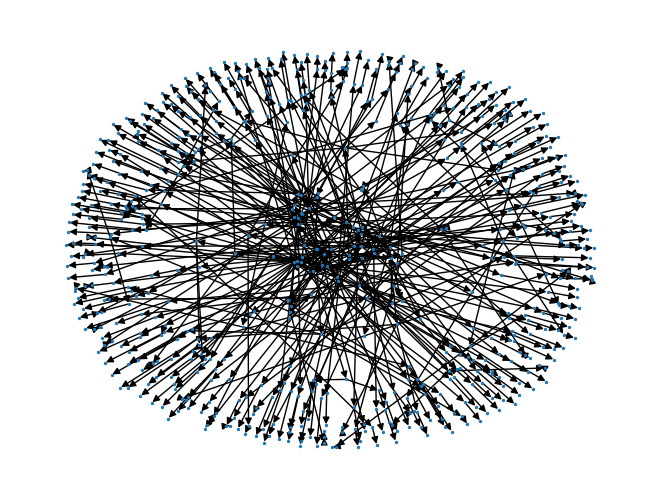

In [104]:
nx.draw(G,node_size=2)

This hairball is not a canonical visualization of a tree. Let's use a different layout. A more pleasing visualization of a tree is a [radial tree](https://en.wikipedia.org/wiki/Radial_tree). 

![Image of radial layout](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e1/Radial_tree_-_Graphic_Statistics_in_Management.svg/720px-Radial_tree_-_Graphic_Statistics_in_Management.svg.png)


This is available to us as part of networkx which includes sections of the pydot library and some graphviz layout algorithms. We are interested in the `twopi` layout of a tree.  We drive the edge colors based on the prefix code of the leaf nodes. Optionally we drive the edge labels using the prefix code of node. We next drive the size of the vertices and the edge width based on the icident counts for each prefix code.

Here I use arebitray functions to map the values to edge widths and vertex sizes. If `n` is the number of incidents for a prefix code, The edge widths are mapped to `math.log(n,200)` and the vertex sizes are mapped to `(n/1000)*5`. 

In [105]:
#collapse-hide
fig, ax = plt.subplots(figsize=(12,12))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
# pos = nx.planar_layout(G)
pos = nx.nx_pydot.graphviz_layout(gg, prog="twopi")


c_x,c_y = pos[rename_dict['s']]

# vertex colors

colors = list(mcolors.TABLEAU_COLORS.keys())
used_colors = []

vertex_colors = []
vertex_color_dict = {}

    
# color vertex if it is of type int white if it is not
for v in gg.nodes:
    if type(v) == int:
        first_digits = str(v).zfill(4)[0:1]
        if first_digits not in vertex_color_dict:
            vertex_color_dict[first_digits] = random.choice(list(set(colors) - set(used_colors)))
            used_colors.append(vertex_color_dict[first_digits])
            vertex_colors.append(vertex_color_dict[first_digits])
        else:
            vertex_colors.append(vertex_color_dict[first_digits])
    else:
        vertex_colors.append('black')

# edge colors

edge_colors = [ vertex_color_dict[str(v).zfill(4)[0:1]] if isinstance(v,int) else 'grey' for u,v in gg.edges]


# edge labels

edge_labels = {}
for e in gg.edges:
    if type(e[1]) == int:
        edge_labels[(e[0],e[1])] = str(e[1]).zfill(4)
    else:
        edge_labels[(e[0],e[1])] = e[1].split('_')[0]

# vertex size 

counts = {}
vertex_size = []
for v in tqdm(gg.nodes):
    if type(v) == int:
        code = str(v).zfill(4)
        # count the number of incidents with this code
        n = c_indexed[c_indexed["OFFENSE_CODE"] == code].count()["INCIDENT_NUMBER"]
        counts[v] = n
        # log scale
        vertex_size.append((n/1000)*5)
    else:
        vertex_size.append(0.01)

# edge width

edge_width = [math.log(counts[v],200) if isinstance(v,int) else 0.2 for u,v in gg.edges]


nx.draw_networkx_edges(gg,pos,ax=ax,edge_color=edge_colors,width=edge_width,arrows=False)

nx.draw_networkx_nodes(gg,pos=pos,node_size=vertex_size,node_color=vertex_colors,ax=ax)
#nx.draw_networkx_labels(gg,labels=labb,pos=pos,font_size=5,ax=ax,font_color='white')
nx.draw_networkx_edge_labels(gg,pos,edge_labels=edge_labels,ax=ax,font_size=3.5,font_color='black',label_pos=0.4)
buf = io.BytesIO()
fig.savefig('plots/categories_twopi_lab_color.svg')
ax.set_title('Categories',fontsize=20)
fig.savefig(buf)
buf.seek(0)
plt.close(fig)
im = Image.open(buf)
im.save('plots/categories_twopi_lab_color.png')
# save pos as json
with open('plots/pos_twopi_color.json', 'w') as fp:
    json.dump(pos, fp)

100%|██████████| 637/637 [00:09<00:00, 64.53it/s]


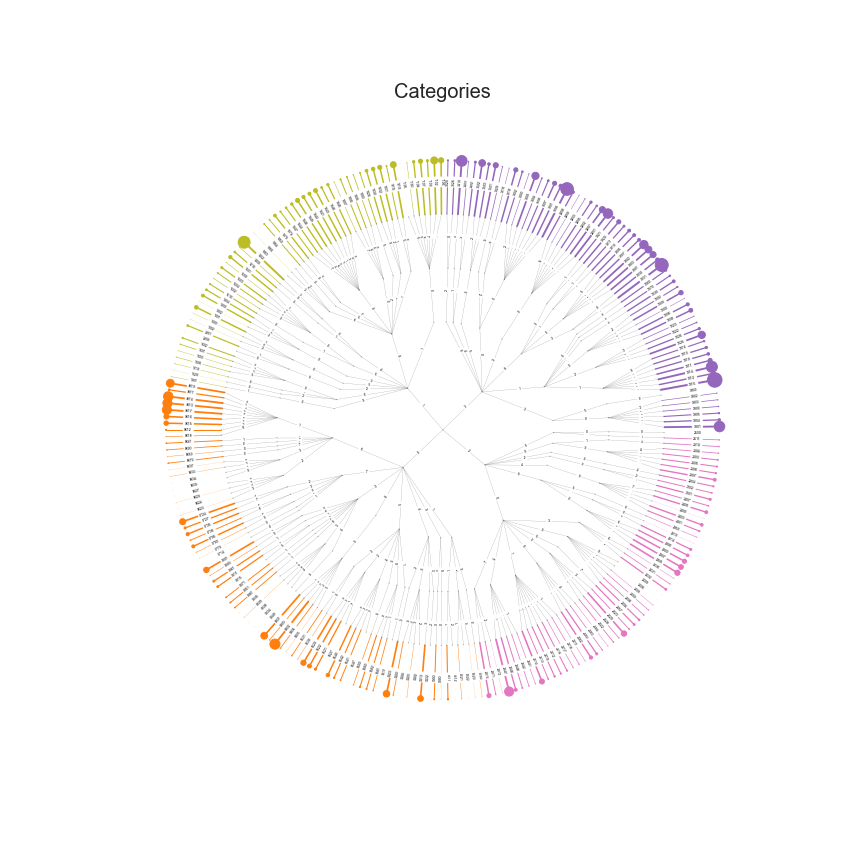

In [13]:
#hide
im

Let's take a look at the resulting vizualization.

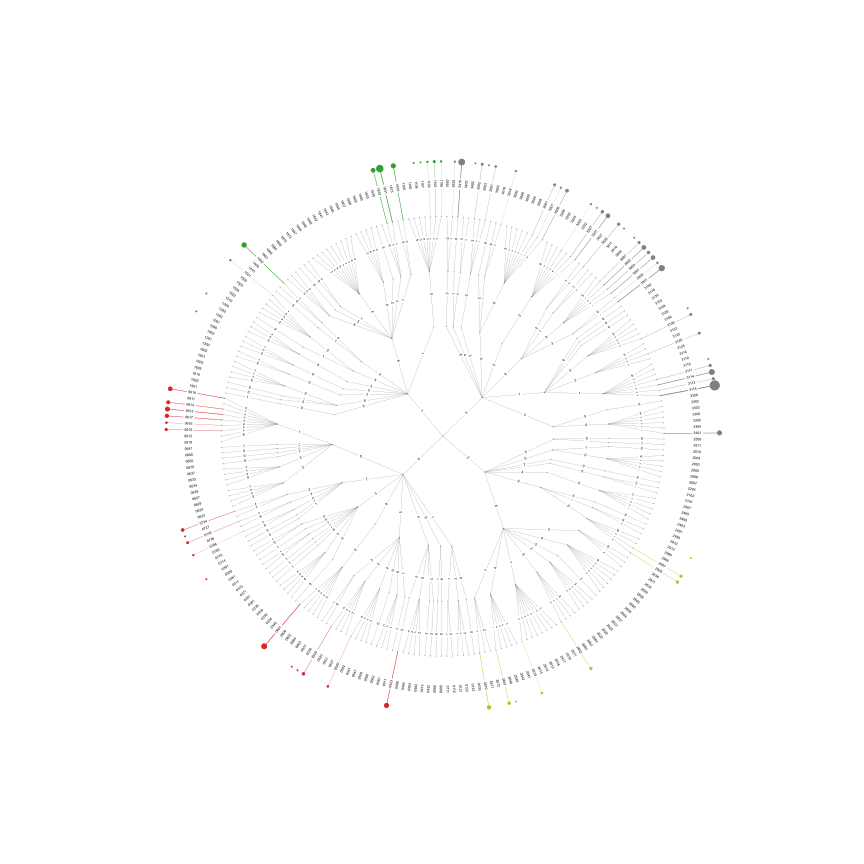

In [127]:
style = "<style>svg{width:100% !important;height:100% !important;</style>"
display(HTML(style))
SVG('plots/categories_twopi_lab_color.svg')

Here, each color is associated with codes that share the same prefix at a particular position. For example 0001 and 0000 share the same parent node corresponding to the prefix 000. The scales are arbitrary and thus need trial and error to make them work with the visualization. As you can see the circles are impossible to see for some incidents. Some incident counts are just too low to be visible. An alternative visualization could use the normalized incident counts to drive the size of the circles.

Time for some animations. Let us make the plot move with time. This visualization is by no means a replacement for the humble line plot but an aid to help the user demand the right plots to later visualize. We begin by sorting the dataframe by its index. Here the index is the column `OCCURRED_ON_DATE`.

We can now group by the `OFFENSE_CODE` column and count the number of occurrences per [rolling](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html) window. We can use these counts to drive the plot and generate frames of the animation. Let us take a look at slice of the output.

In [15]:
c_indexed
df = pd.crosstab(combined_typed["OCCURRED_ON_DATE"].dt.to_period('2W'), combined_typed['OFFENSE_CODE'])
df


OFFENSE_CODE           0100  0111  0112  0121  0122  0123  0300  0301  0311  \
OCCURRED_ON_DATE                                                              
2015-06-15/2015-06-21     0     0     0     0     0     0     0    13     3   
2015-06-22/2015-06-28     0     0     0     0     0     0     0    13     3   
2015-06-29/2015-07-05     0     3     0     0     0     0     0    20     0   
2015-07-06/2015-07-12     0     3     0     0     0     0     0    22     2   
2015-07-13/2015-07-19     0     0     0     0     0     0     0    20     3   
...                     ...   ...   ...   ...   ...   ...   ...   ...   ...   
2022-06-13/2022-06-19     0     1     0     0     0     0     0    18     0   
2022-06-20/2022-06-26     0     0     0     0     0     0     0    21     0   
2022-06-27/2022-07-03     0     0     0     0     0     0     0    12     0   
2022-07-04/2022-07-10     0     0     0     0     0     0     0    16     0   
2022-07-11/2022-07-17     0     0     0     0     0     0     0     1     0   

OFFENSE_CODE           0315  ...  3803  3805  3807  3810  3811  3820  3821  \
OCCURRED_ON_DATE             ...                                             
2015-06-15/2015-06-21     0  ...    20     9    11     1     1     4     1   
2015-06-22/2015-06-28     0  ...    31     2     5     7     6     6     0   
2015-06-29/2015-07-05     0  ...    30     5     3     2     6     7     1   
2015-07-06/2015-07-12     0  ...    23    10     4     9     6    11     4   
2015-07-13/2015-07-19     0  ...    33     1     1    12     7     7     1   
...                     ...  ...   ...   ...   ...   ...   ...   ...   ...   
2022-06-13/2022-06-19     0  ...    16     6     4     8     4    13     0   
2022-06-20/2022-06-26     0  ...    10     5     6     9     1    12     1   
2022-06-27/2022-07-03     0  ...    19     8     2     5     1     5     1   
2022-07-04/2022-07-10     0  ...    21     0     4     8     1     9     3   
2022-07-11/2022-07-17     0  ...     6     1     4     0     1     5     0   

OFFENSE_CODE           3830  3831  99999  
OCCURRED_ON_DATE                          
2015-06-15/2015-06-21     8    73      0  
2015-06-22/2015-06-28    10    97      0  
2015-06-29/2015-07-05     5    72      0  
2015-07-06/2015-07-12     6    90      0  
2015-07-13/2015-07-19    10    80      0  
...                     ...   ...    ...  
2022-06-13/2022-06-19     6    94      0  
2022-06-20/2022-06-26     5    76      0  
2022-06-27/2022-07-03     3   100      0  
2022-07-04/2022-07-10     5    71      0  
2022-07-11/2022-07-17     2    28      0  

[370 rows x 254 columns]

We can now build a list of count dictionaries for each time period. We can then use these dictionaries to drive the plot using the same code.

In [107]:
i_s = df.index.to_series().values.tolist()

count_list = []
for ix,i in tqdm(enumerate(i_s)):
    counts = {}
    d = df.iloc[ix,:].to_dict()
    for v in gg.nodes:
        if type(v) == int:
            code = str(v).zfill(4)
            counts[v] = d[code]
    count_list.append(counts)

370it [00:00, 2751.95it/s]


In [108]:
#collapse-hide
frames = []
for counts in tqdm(count_list):
    vertex_size = []
    for v in gg.nodes:
        if type(v) == int:
            code = str(v).zfill(4)
            n = counts[v]
            vertex_size.append(n)
        else:
            vertex_size.append(0.01)
    fig, ax = plt.subplots(figsize=(12,12))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # pos = nx.planar_layout(G)
    pos = nx.nx_pydot.graphviz_layout(gg, prog="twopi")
    c_x,c_y = pos[rename_dict['s']]
    edge_colors = [ vertex_color_dict[str(v).zfill(4)[0:1]] if isinstance(v,int) else 'grey' for u,v in gg.edges]
    edge_width = [math.log(max(0.1,counts[v]),200) if isinstance(v,int) else 0.2 for u,v in gg.edges]
    nx.draw_networkx_edges(gg,pos,ax=ax,edge_color=edge_colors,width=edge_width,arrows=False)
    nx.draw_networkx_nodes(gg,pos=pos,node_size=vertex_size,node_color=vertex_colors,ax=ax)
    #nx.draw_networkx_labels(gg,labels=labb,pos=pos,font_size=5,ax=ax,font_color='white')
    nx.draw_networkx_edge_labels(gg,pos,edge_labels=edge_labels,ax=ax,font_size=3.5,font_color='black',label_pos=0.4)
    buf = io.BytesIO()
    fig.savefig('plots/categories_twopi_lab_color.svg')
    fig.savefig(buf)
    buf.seek(0)
    plt.close(fig)
    im = Image.open(buf)
    frames.append(im)
gif_name = 'plots/categories_twopi_lab_color.gif'
frames[0].save(gif_name, format='GIF', append_images=frames[1:], save_all=True, duration=100, loop=0)

100%|██████████| 370/370 [25:27<00:00,  4.13s/it]


Adding a timestamp to the plot should help us understand the plot better. We will use PIL to add the timestamp to the plot since generating the matplotlib frames again is a computationally expensive operation.

In [110]:
from PIL import ImageDraw
new_frames = []
for i,frame in enumerate(frames):
    im = frames[i].copy()
    # add frame to image
    draw = ImageDraw.Draw(im)
    draw.text((130,130), str(i_s[i]), fill=(0,0,0))
    new_frames.append(im)
gif_name = 'plots/categories_twopi_lab_color.gif'
new_frames[0].save(gif_name, format='GIF', append_images=new_frames[1:], save_all=True, duration=100, loop=0)

![gif](plots/categories_twopi_lab_color.gif)

## Grouping Incidents II (Time Series Clustering)

Anohter way to group this data is to first convert the incident counts to a min-max normalized (0-1) time series and clustering the different codes together based on Time Series CLustering methods. Two methods are descibed in this [Kaggle notebook](https://www.kaggle.com/code/izzettunc/introduction-to-time-series-clustering/notebook). We will be using K-means clustering from the package `tslearn` for this task.

We first convert the `i_s` index list to a datetime object list. This will help us plot the time series with appropriate x-axis labels.

In [112]:
yx = [datetime.datetime.fromtimestamp(int(i.to_timestamp().timestamp())) for i in i_s]

We now build a list of lists of each incident code. These lists are time series 

In [113]:
count_series = {}
for v in gg.nodes:
    if type(v) == int:
        code = str(v).zfill(4)
        count_series[v] = df[code].to_list()

In [19]:
count_normalized_series = {}
for k,v in count_series.items():
    vals =  np.array(v)
    # count_normalized_series[k] = (vals - np.mean(vals))/np.std(vals)
    _min = np.min(vals)
    _max = np.max(vals)
    count_normalized_series[k] = (vals-_min)/(_max-_min)

In [20]:
data_index = list(count_normalized_series.keys())
data = np.array(list(count_normalized_series.values()))

In [ ]:
#hide
som_x = som_y = math.ceil(math.sqrt(math.sqrt(data.shape[0])))
som = MiniSom(som_x,som_x,data.shape[1], sigma=0.3, learning_rate = 0.1)
som.train(data, 6000)
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()
plot_som_series_averaged_center(4,4,win_map)
#Using `dtw_barycenter_averaging` instead of averaging across plots
def plot_som_series_dba_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(dtw_barycenter_averaging(np.vstack(win_map[cluster])),c="red") # I changed this part
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")
    plt.show()
plot_som_series_dba_center(4,4,win_map)
#Let's take a look at the number of incident types in each cluster
for i in range(4):
    for j in range(4):
        print("Cluster : " + str((i,j)) + " : " + str(len(win_map[(i,j)])))

Next we will try using TimeSeriesKMeans to cluster the time series. 

In [51]:
cluster_count = math.ceil(math.sqrt(len(data))) # number of clusters
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="euclidean")
labels = km.fit_predict(data)

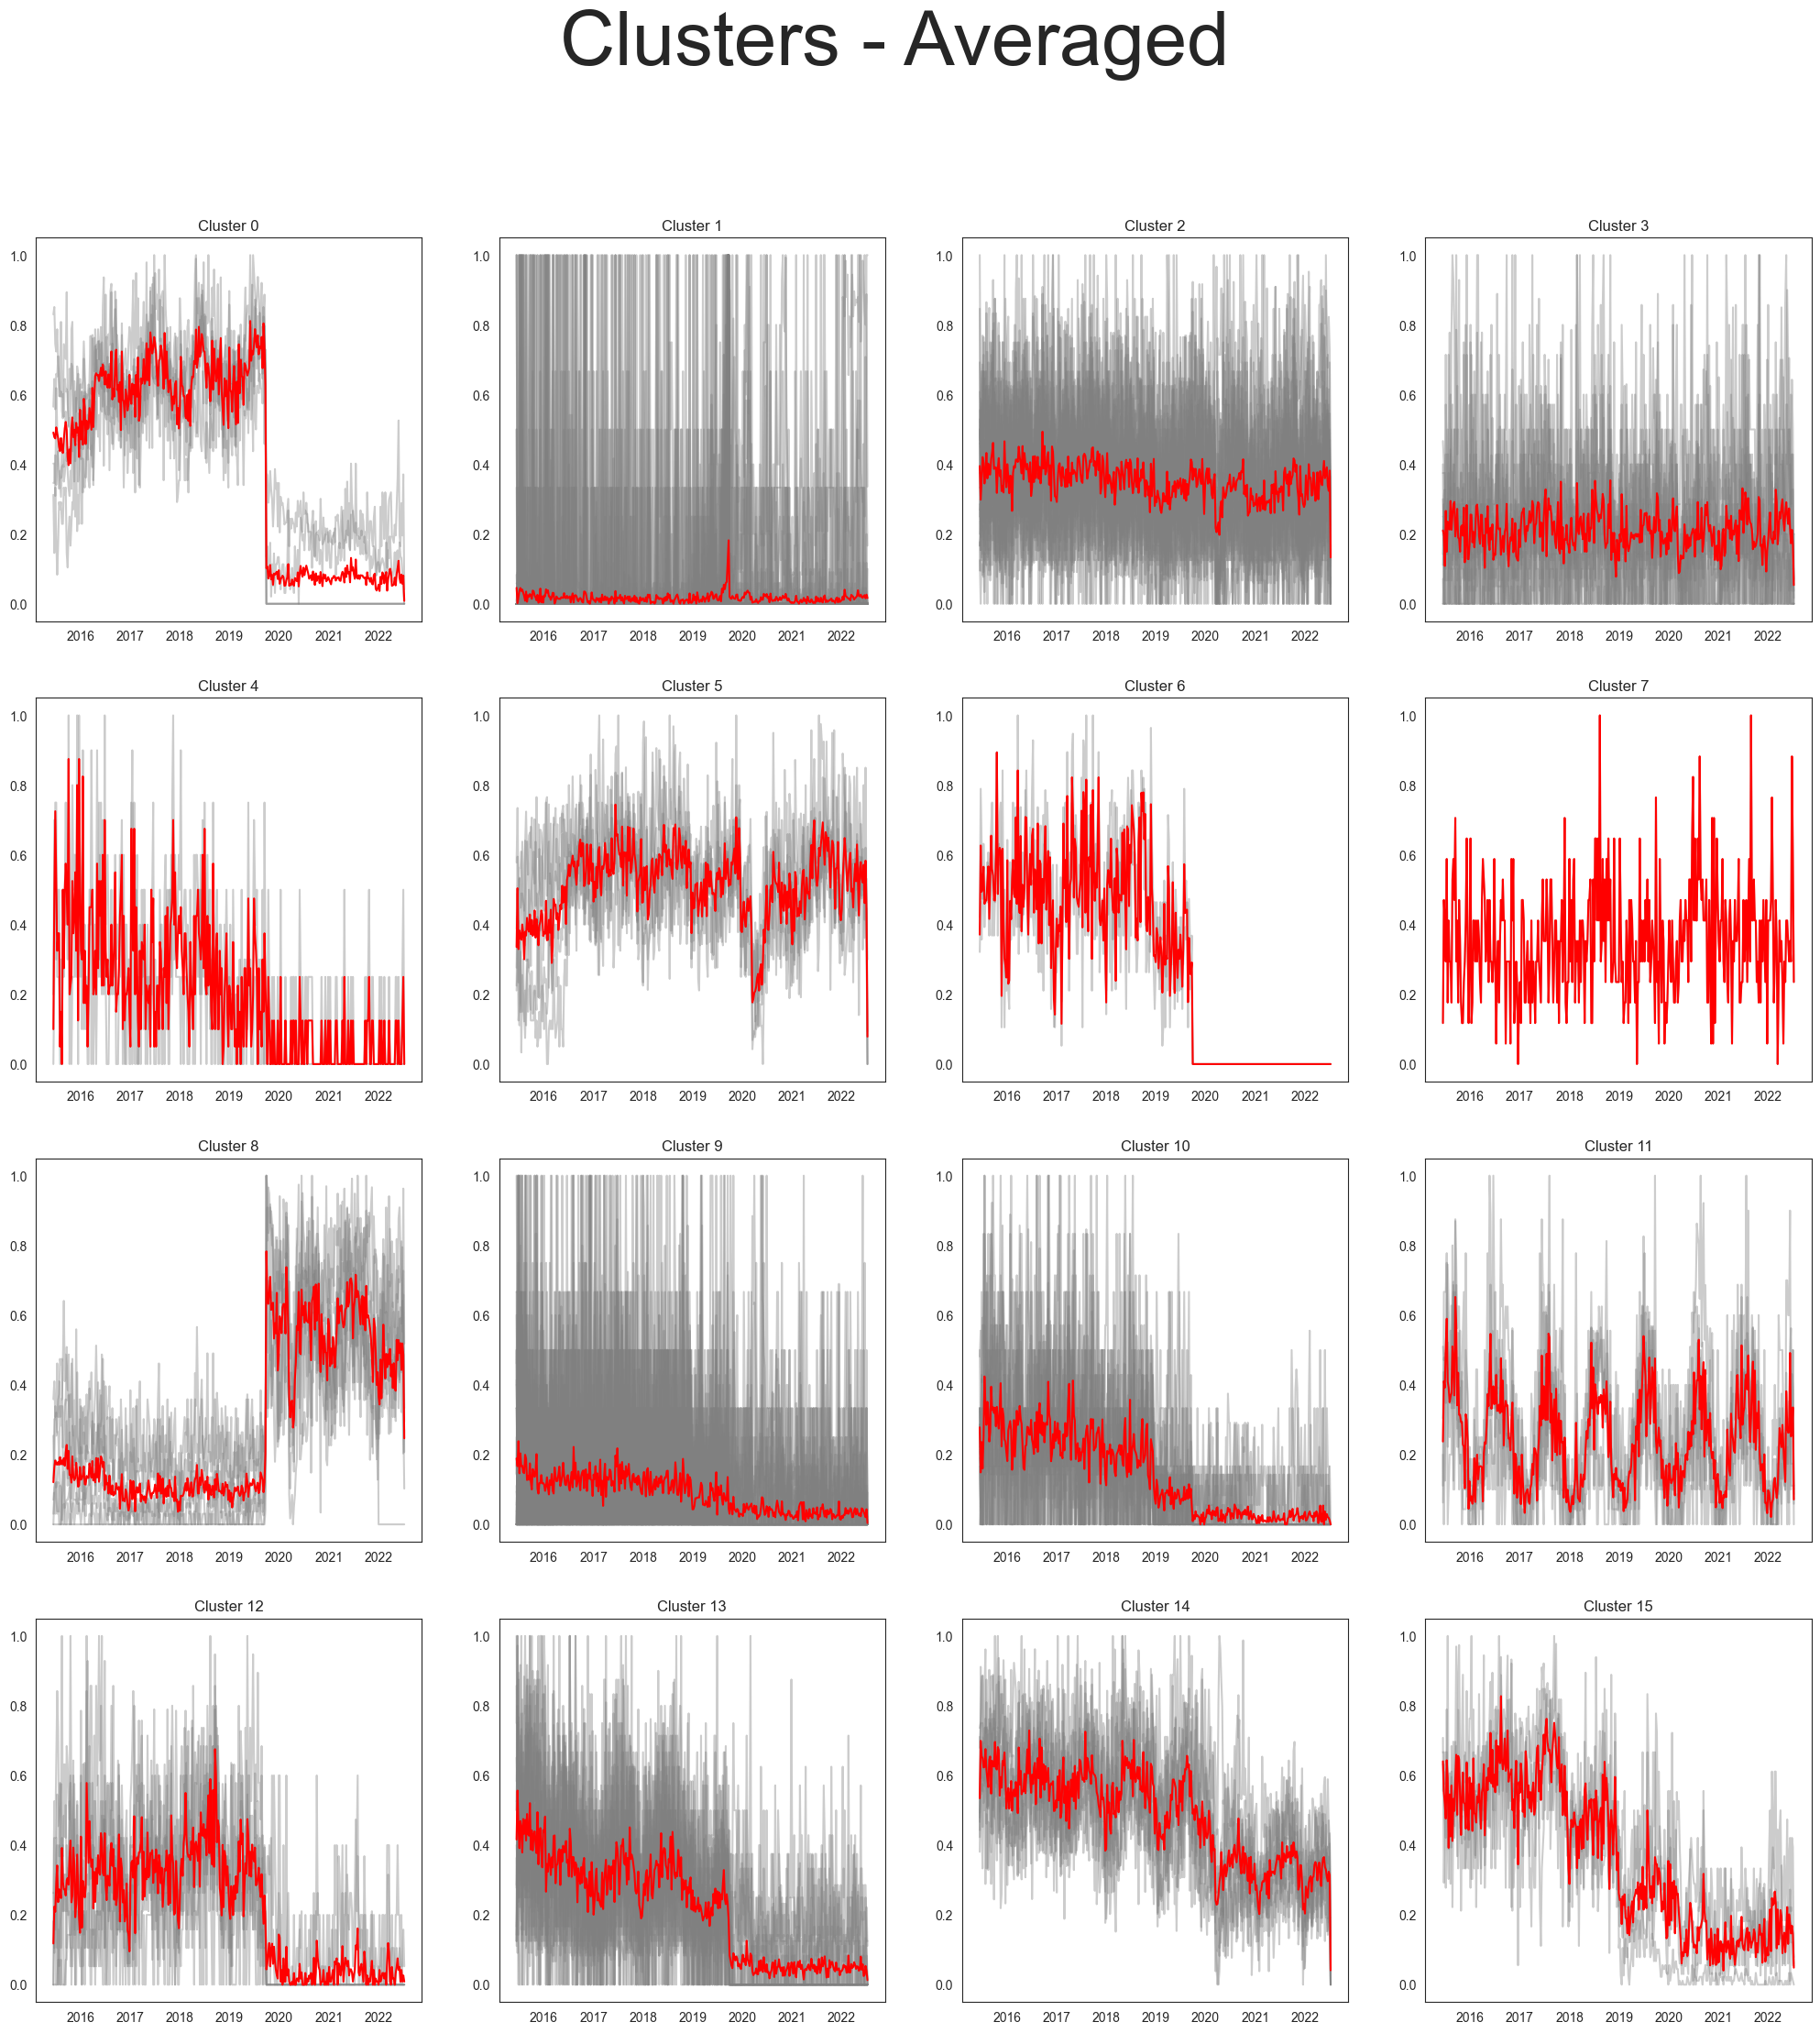

In [115]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters - Averaged',fontsize=60)
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(yx,data[i],c="gray",alpha=0.4)
                cluster.append(data[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(yx,np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(label))
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    axs[row_i, column_j].xaxis.set_major_locator(locator)
    axs[row_i, column_j].xaxis.set_major_formatter(formatter)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

Here the red line is the average time series for the cluster.

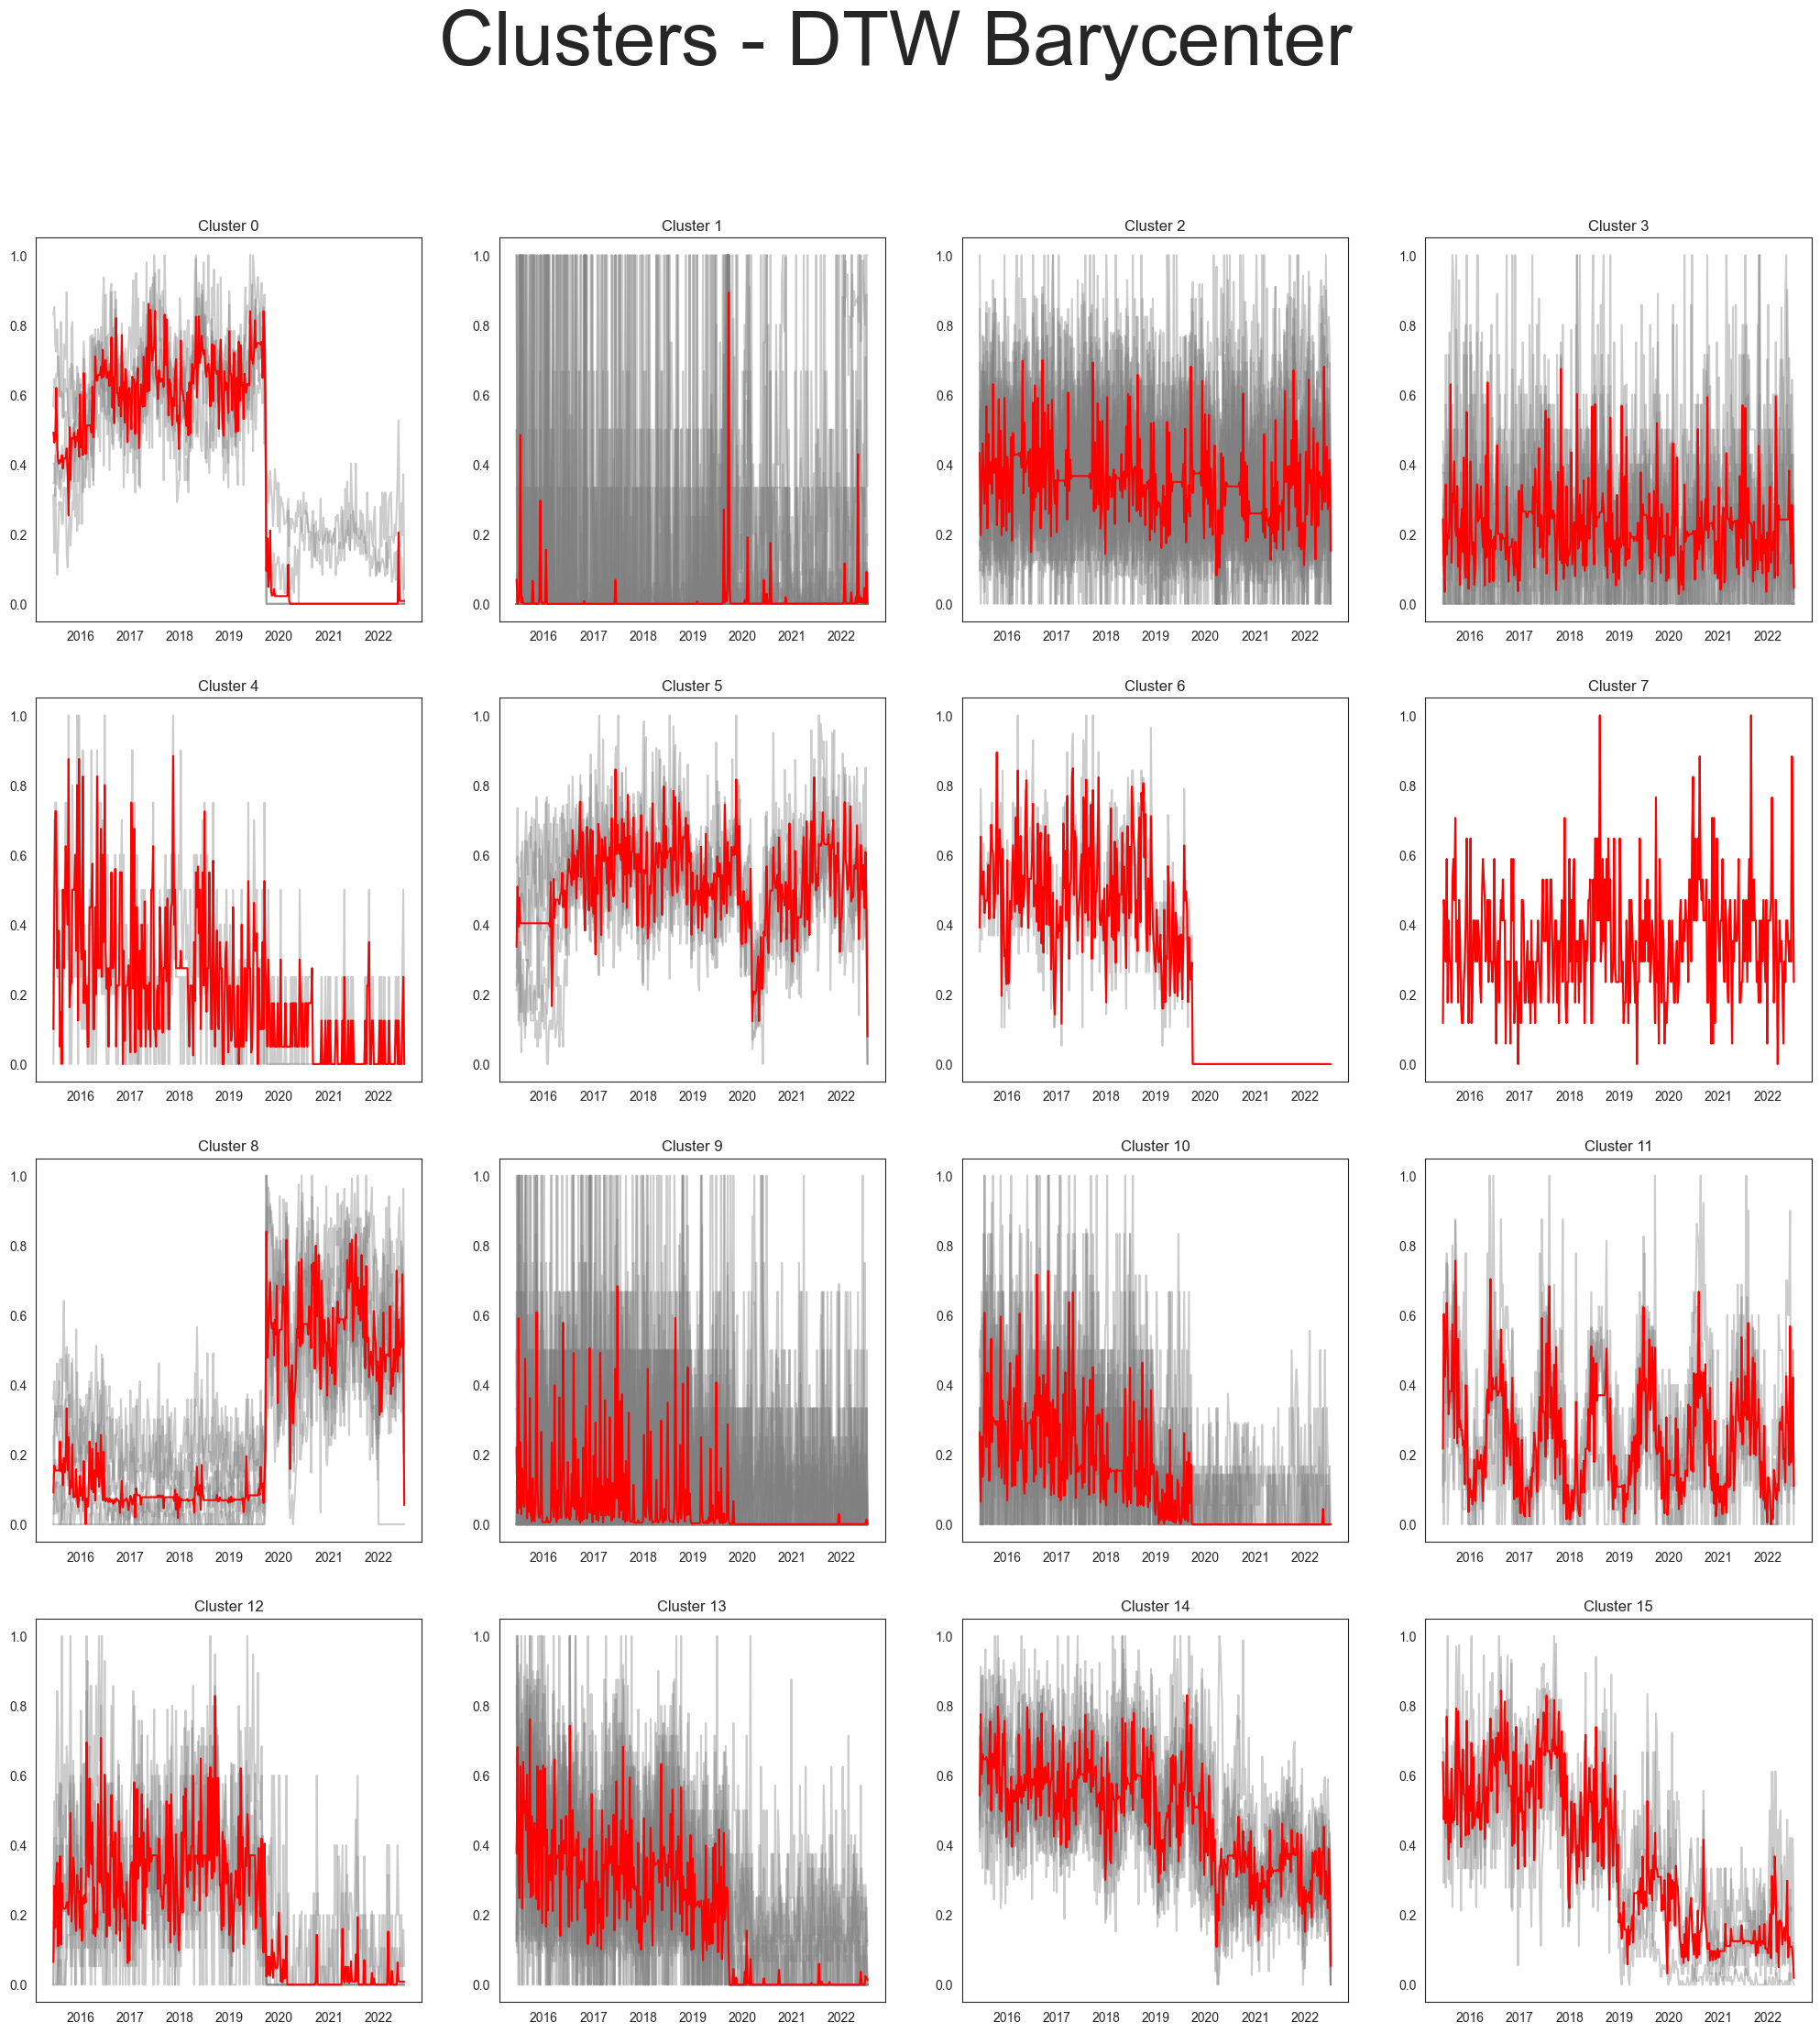

In [133]:
#hide
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters - DTW Barycenter',fontsize=60)
row_i=0
column_j=0
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(yx,data[i],c="gray",alpha=0.4)
                cluster.append(data[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(yx,dtw_barycenter_averaging(np.vstack(cluster)),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(label))
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    axs[row_i, column_j].xaxis.set_major_locator(locator)
    axs[row_i, column_j].xaxis.set_major_formatter(formatter)
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

How many incidents do we have per cluster?

Cluster : 0 : 5
Cluster : 1 : 98
Cluster : 2 : 23
Cluster : 3 : 11
Cluster : 4 : 2
Cluster : 5 : 5
Cluster : 6 : 2
Cluster : 7 : 1
Cluster : 8 : 7
Cluster : 9 : 42
Cluster : 10 : 15
Cluster : 11 : 5
Cluster : 12 : 6
Cluster : 13 : 18
Cluster : 14 : 9
Cluster : 15 : 4


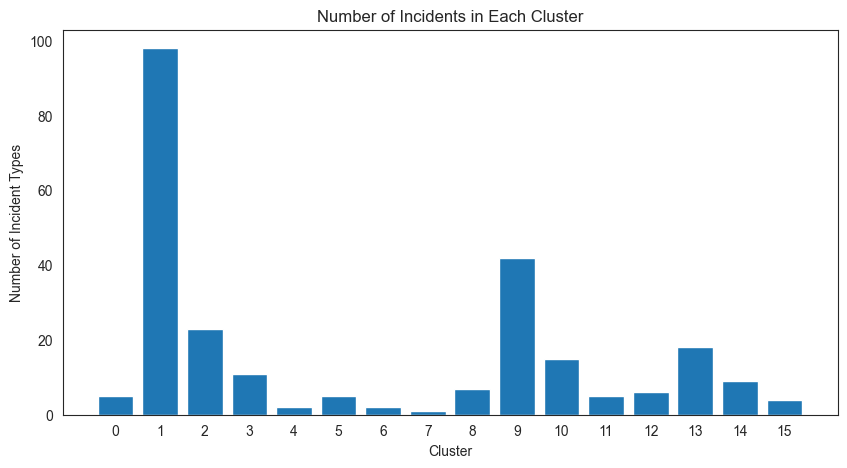

In [132]:
# plot number of incidents in each cluster
pdata = []
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                cluster.append(data[i])
    pdata.append((label,len(cluster)))
    print("Cluster : " + str(label) + " : " + str(len(cluster)))
# plot pdata
fig, ax = plt.subplots(figsize=(10,5))
ax.bar([str(x[0]) for x in pdata],[x[1] for x in pdata])
ax.set_title("Number of Incidents in Each Cluster")
ax.set_xlabel("Cluster")
ax.set_ylabel("Number of Incident Types")
plt.show()

In [54]:
label_map = {}
for i in range(len(labels)):
    label_map[data_index[i]] = labels[i]

Let's take a look at some of the clusters.

In [59]:
#hide
cluster_number = 0
for k,v in label_map.items():
    if v == cluster_number:
        code = str(k).zfill(4)
        description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
        print(f"{k} : {description}")

3301 : VERBAL DISPUTE
3006 : SICK/INJURED/MEDICAL - PERSON
802 : ASSAULT SIMPLE - BATTERY
413 : ASSAULT - AGGRAVATED - BATTERY
2629 : HARASSMENT


Cluster 1 is the largest cluster with 98 incidents. For cluster 1 incidents we have rare types with intermittent peaks.

In [70]:
#collapse-hide
cluster_number = 1
display(Markdown(f"### Codes for Cluster {cluster_number}"))
for k,v in label_map.items():
    if v == cluster_number:
        code = str(k).zfill(4)
        description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
        print(f"{k} : {description}")


### Codes for Cluster 1

3300 : Migrated Report - Other Part III
3303 : NOISY PARTY/RADIO-ARREST
3302 : GATHERING CAUSING ANNOYANCE
3350 : Migrated Report - Injured/Medical/Sick Assist
3126 : WARRANT ARREST - OUTSIDE OF BOSTON WARRANT
3123 : EXPLOSIVES - TURNED IN OR FOUND
3100 : Migrated Report - Investigate Property
3203 : FIREARM/WEAPON - LOST
3200 : Migrated Report - Investigate Person
3000 : Migrated Report - Death Investigation
3016 : FIREARM/WEAPON - ACCIDENTAL INJURY / DEATH
3029 : PRISONER - SUICIDE / SUICIDE ATTEMPT
3403 : PROTECTIVE CUSTODY / SAFEKEEPING
1108 : FRAUD - WELFARE
1100 : Migrated Report - Fraud
1105 : FRAUDS - ALL OTHER
1831 : SICK ASSIST
1800 : Migrated Report - Drugs - Possession/Manufacturing/Distribute
1807 : DRUGS - CLASS D TRAFFICKING OVER 50 GRAMS
1864 : DRUGS - POSS CLASS D - INTENT MFR DIST DISP
1866 : DRUGS - POSS CLASS E INTENT TO MF DIST DISP
1863 : DRUGS - POSS CLASS D - MARIJUANA, ETC.
1400 : Migrated Report - Vandalism/Destruction of Property
1500 : Migrated Report - Weap

Cluster 8 has events that have dramatically increased since the end of 2019. Coinciding with the onset of the pandemic.

In [71]:
#collapse-hide
cluster_number = 8
display(Markdown(f"### Codes for Cluster {cluster_number}"))
for k,v in label_map.items():
    if v == cluster_number:
        code = str(k).zfill(4)
        description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
        print(f"{k} : {description}")

### Codes for Cluster 8

3005 : SICK ASSIST
1810 : DRUGS - POSSESSION/ SALE/ MANUFACTURING/ USE
1832 : SICK ASSIST - DRUG RELATED ILLNESS
801 : ASSAULT - SIMPLE
423 : ASSAULT - AGGRAVATED
2670 : HARASSMENT/ CRIMINAL HARASSMENT
2905 : VAL - VIOLATION OF AUTO LAW


Clusters 12,0,13 and 10 have events that have decreased since the end of 2019. Coinciding with the onset of the pandemic.

In [58]:
#collapse-hide
cluster_number = 0
display(Markdown(f"### Codes for Cluster {cluster_number}"))
for k,v in label_map.items():
    if v == cluster_number:
        code = str(k).zfill(4)
        description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
        print(f"{k} : {description}")

3301 : VERBAL DISPUTE
3006 : SICK/INJURED/MEDICAL - PERSON
802 : ASSAULT SIMPLE - BATTERY
413 : ASSAULT - AGGRAVATED - BATTERY
2629 : HARASSMENT


In [72]:
#collapse-hide
cluster_number = 12
display(Markdown(f"### Codes for Cluster {cluster_number}"))
for k,v in label_map.items():
    if v == cluster_number:
        code = str(k).zfill(4)
        description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
        print(f"{k} : {description}")

### Codes for Cluster 12

3208 : PROPERTY - MISSING
1843 : DRUGS - POSS CLASS B - INTENT TO MFR DIST DISP
1841 : DRUGS - POSS CLASS A - INTENT TO MFR DIST DISP
1848 : DRUGS - POSS CLASS D - INTENT TO MFR DIST DISP
2646 : LIQUOR/ALCOHOL - DRINKING IN PUBLIC
2619 : FUGITIVE FROM JUSTICE


In [73]:
#collapse-hide
cluster_number = 13
display(Markdown(f"### Codes for Cluster {cluster_number}"))
for k,v in label_map.items():
    if v == cluster_number:
        code = str(k).zfill(4)
        description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
        print(f"{k} : {description}")

### Codes for Cluster 13

3109 : SERVICE TO OTHER PD INSIDE OF MA.
3160 : FIRE REPORT - CAR, BRUSH, ETC.
3002 : ANIMAL CONTROL - DOG BITES - ETC.
1106 : FRAUD - CREDIT CARD / ATM FRAUD
1830 : DRUGS - SICK ASSIST - HEROIN
1844 : DRUGS - POSS CLASS C
1503 : WEAPON - OTHER - CARRYING / POSSESSING, ETC
1304 : PROPERTY - STOLEN THEN RECOVERED
1300 : STOLEN PROPERTY - BUYING / RECEIVING / POSSESSING
611 : LARCENY PICK-POCKET
522 : BURGLARY - RESIDENTIAL - NO FORCE
521 : BURGLARY - RESIDENTIAL - ATTEMPT
542 : BURGLARY - COMMERICAL - NO FORCE
2660 : OTHER OFFENSE
2632 : EVADING FARE
2906 : VAL - OPERATING UNREG/UNINS Â CAR
2914 : VAL - OPERATING W/O AUTHORIZATION LAWFUL
2405 : DISORDERLY CONDUCT


In [74]:
#collapse-hide
cluster_number = 10
display(Markdown(f"### Codes for Cluster {cluster_number}"))
for k,v in label_map.items():
    if v == cluster_number:
        code = str(k).zfill(4)
        description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
        print(f"{k} : {description}")

### Codes for Cluster 10

3304 : NOISY PARTY/RADIO-NO ARREST
3305 : DRUNKENNESS
3102 : INVESTIGATION FOR ANOTHER AGENCY
3170 : INTIMIDATING WITNESS
1845 : DRUGS - POSS CLASS D
1846 : DRUGS - POSS CLASS E
1874 : DRUGS - OTHER
1510 : WEAPON - FIREARM - OTHER VIOLATION
311 : ROBBERY - COMMERCIAL
560 : BURGLARY - OTHER - FORCE
2401 : AFFRAY
2204 : LIQUOR LAW VIOLATION
2007 : VIOLATION - RESTRAINING ORDER (NO ARREST)
2006 : VIOL. OF RESTRAINING ORDER W ARREST
2005 : CHILD ENDANGERMENT


Cluster 11 has events that have stayed relatively periodic since 2015.

In [75]:
#collapse-hide
cluster_number = 11
display(Markdown(f"### Codes for Cluster {cluster_number}"))
for k,v in label_map.items():
    if v == cluster_number:
        code = str(k).zfill(4)
        description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
        print(f"{k} : {description}")

### Codes for Cluster 11

3810 : M/V ACCIDENT - INVOLVING BICYCLE - INJURY
3811 : M/V ACCIDENT - INVOLVING BICYCLE - NO INJURY
3402 : ANIMAL INCIDENTS (DOG BITES, LOST DOG, ETC)
616 : LARCENY THEFT OF BICYCLE
706 : AUTO THEFT - MOTORCYCLE / SCOOTER


Not much has changed in Bicycle related incidents since 2015. We can also take a look at the plots of the incidents of a cluster separately to verify the clustering.

In [116]:
#collapse-hide
def plotCluster(data, labels, cluster_number):
    descriptions = {}
    for k,v in label_map.items():
        if v == cluster_number:
            code = str(k).zfill(4)
            description = combined_typed[combined_typed["OFFENSE_CODE"] == code]["OFFENSE_DESCRIPTION"].values[0]
            descriptions[k] = description
    cols = 3
    rows = math.ceil(len(descriptions)/cols)
    fig, axs = plt.subplots(rows,cols,figsize=(20,8))
    fig.suptitle('Cluster ' + str(cluster_number),fontsize=16)
    row_i=0
    column_j=0
    # For each label there is,
    # plots every series with that label
    for k,v in descriptions.items():
        axs[row_i, column_j].plot(yx,data[data_index.index(k)],c="gray",alpha=0.4)
        axs[row_i, column_j].set_title(f"{v}")
        locator = mdates.AutoDateLocator()
        formatter = mdates.ConciseDateFormatter(locator)
        axs[row_i, column_j].xaxis.set_major_locator(locator)
        axs[row_i, column_j].xaxis.set_major_formatter(formatter)
        column_j+=1
        if column_j%cols == 0:
            row_i+=1
            column_j=0
    plt.show()

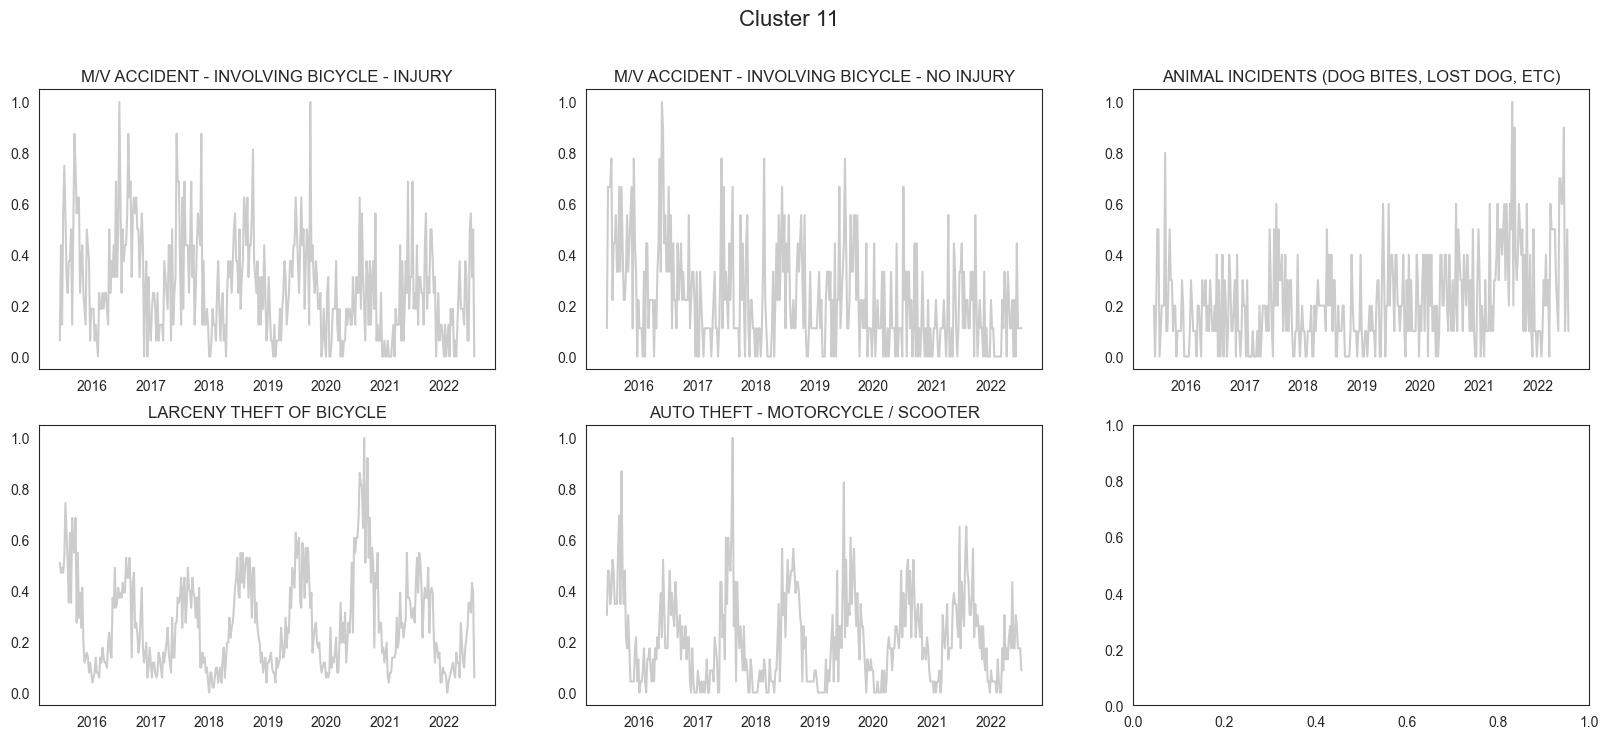

In [117]:
plotCluster(data, labels, 11)

As a sanity check we can also view the raw data without normalization to check if the results are similar.

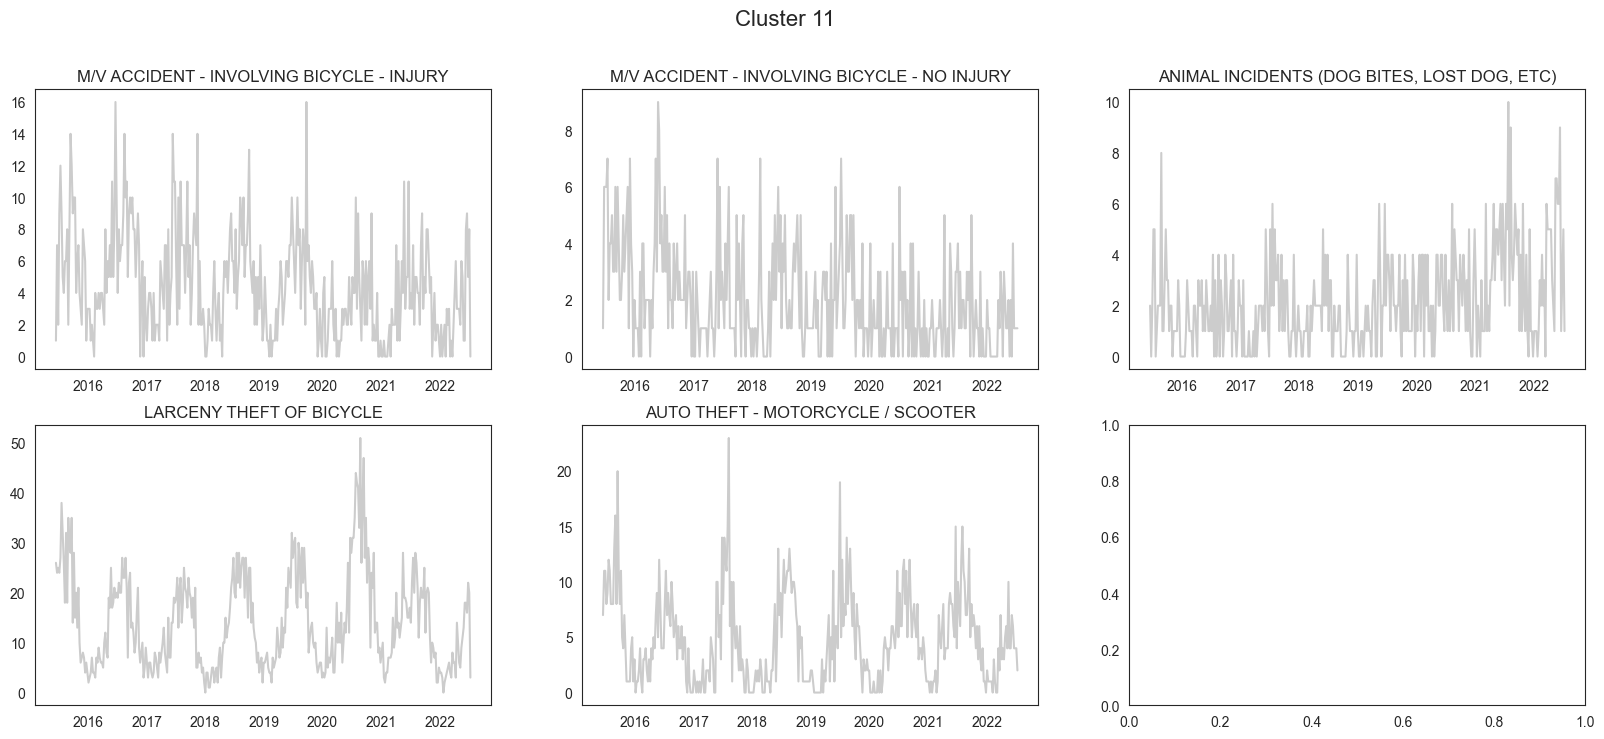

In [120]:
data_raw = np.array(list(count_series.values()))
plotCluster(data_raw, labels, 11)

# Thinking about the Data

I set out with the goal of using data visualization and analysis to convince a friend about th esafety of a certain area. However, to compare the data to the actual experience of living in an area is akin to spurious correlation. The data for example depends on a variety of factors. If staff was able to file the reports, funds allocated to different programs at the BPD, unemployment in an area, schools in an area. The data is influenced by a multitude of confounding factors. Property rates are often in a feedback loop with reports of crime. Where one influences the other. This curse of inferring causality from correlation is a common problem in data science. However we shall not be making that mistake here today. An exploration of the data is not enough to convince a friend but it is a stepping stone towards using data to ask questions of governance. For example, asking about the allocation of funds to different programs or asking the state to explain the reason for changes in the data.